## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum-Classical Neural Networks and Classical Convolutional Neural Networks on the MESSIDOR dataset. The MESSIDOR dataset is a diabetic-retinopathy dataset with 1544 fundus images. The dataset was produced in France and is labeled with five-category classification (no diabetic retinopathy, mild diabetic retinopathy, moderate diabetic retinopathy, severe diabetic retinopathy, and proliferative diabetic retinopathy).

### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.4 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/"

### Classical CNN Model Construction and General Methods

In [ ]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
class TwoClassImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)

        self.class_to_idx = {
            'anormal': 0,
            'bsuspectglaucoma': 1,
            'cglaucoma': 1
        }

    def __getitem__(self, index):
        # Get original image and label
        path, original_target = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            sample = self.transform(sample)

        target_class_name = self.classes[original_target]
        target = self.class_to_idx[target_class_name]

        return sample, target

In [ ]:
def load_data(batch_size, dataset, PAPILA_dual_class=False):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

    if PAPILA_dual_class:
      train_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
      val_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'val'), transform=valid_test_transform)
      test_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'test'), transform=valid_test_transform)

    else:
      train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
      val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
      test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader


  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

  return train_loader, valid_loader, test_loader

### Hybrid Quantum-classical Neural Network Construction

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_auc = float('-inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_auroc > best_val_auc:
            best_val_auc = val_auroc
            best_model_weights = model.state_dict()

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))
  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
  plt.style.use("seaborn")
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

  ax1.plot(quantum_loss, label="With quantum layer")
  ax1.plot(normal_loss, label="Without quantum layer")
  ax1.set_ylabel("Loss")
  ax1.set_ylim([0, 1])
  ax1.set_xlabel("Epoch")
  ax1.legend()

  ax2.plot(quantum_acc, label="With quantum layer")
  ax2.plot(normal_acc, label="Without quantum layer")
  ax2.set_ylabel("Accuracy")
  ax2.set_ylim([0, 100])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  ax2.plot(quantum_auc, label="With quantum layer")
  ax2.plot(normal_auc, label="Without quantum layer")
  ax2.set_ylabel("ROCAUC")
  ax2.set_ylim([0, 1])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch

def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Hybrid model predictions
            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)  # Probability for each class

            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)  # Probability for each class

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)

    # Calculate accuracy
    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)

    # Calculate F1 Score
    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')

    print(f'Hybrid Model Accuracy: {accuracy_hybrid * 100:.2f}%')
    print(f'Normal Model Accuracy: {accuracy_normal * 100:.2f}%')
    print(f'Hybrid Model F1 Score: {f1_hybrid:.4f}')
    print(f'Normal Model F1 Score: {f1_normal:.4f}')

    if num_classes == 2:  # Binary Classification
        # Extract the probabilities of the positive class (class 1)
        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        # Calculate AUC
        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUC: {auc_hybrid:.4f}')
        print(f'Normal Model AUC: {auc_normal:.4f}')

        # Plot ROC curves
        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUC = {auc_hybrid:.4f}')
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
        plt.title('ROC Curve - Hybrid and Normal Models')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Calculate and print AUPR
        precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels, all_probs_hybrid_class1)
        precision_normal, recall_normal, _ = precision_recall_curve(all_labels, all_probs_normal_class1)

        aupr_hybrid = auc(recall_hybrid, precision_hybrid)
        aupr_normal = auc(recall_normal, precision_normal)

        print(f'Hybrid Model AUPR: {aupr_hybrid:.4f}')
        print(f'Normal Model AUPR: {aupr_normal:.4f}')

        # Plot Precision-Recall curves
        plt.figure(figsize=(10, 6))
        plt.plot(recall_hybrid, precision_hybrid, label=f'Hybrid Model AUPR = {aupr_hybrid:.4f}')
        plt.plot(recall_normal, precision_normal, label=f'Normal Model AUPR = {aupr_normal:.4f}')
        plt.title('Precision-Recall Curve - Hybrid and Normal Models')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')
        plt.show()

    else:  # Multi-class Classification
        # For multi-class, handle per class ROC and PR curves
        for i in range(num_classes):
            # Calculate AUC for each class
            fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels == i, all_probs_hybrid[:, i])
            fpr_normal, tpr_normal, _ = roc_curve(all_labels == i, all_probs_normal[:, i])

            auc_hybrid = roc_auc_score(all_labels == i, all_probs_hybrid[:, i])
            auc_normal = roc_auc_score(all_labels == i, all_probs_normal[:, i])

            plt.figure(figsize=(10, 6))
            plt.plot(fpr_hybrid, tpr_hybrid, label=f'Class {i} Hybrid Model AUC = {auc_hybrid:.4f}')
            plt.plot(fpr_normal, tpr_normal, label=f'Class {i} Normal Model AUC = {auc_normal:.4f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve - Class {i}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()

            # Precision-Recall Curve
            precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels == i, all_probs_hybrid[:, i])
            precision_normal, recall_normal, _ = precision_recall_curve(all_labels == i, all_probs_normal[:, i])

            aupr_hybrid = auc(recall_hybrid, precision_hybrid)
            aupr_normal = auc(recall_normal, precision_normal)

            plt.figure(figsize=(10, 6))
            plt.plot(recall_hybrid, precision_hybrid, label=f'Class {i} Hybrid Model AUPR = {aupr_hybrid:.4f}')
            plt.plot(recall_normal, precision_normal, label=f'Class {i} Normal Model AUPR = {aupr_normal:.4f}')
            plt.title(f'Precision-Recall Curve - Class {i}')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend(loc='lower left')
            plt.show()


# Experiments: Training Model on Messidor - Testing on Messidor

In [ ]:
n_epochs = 100
num_classes = 5
q_depth = 4
batch_size = 32
dataset = "Messidor"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Seed Experiment 1

In [ ]:
seed = 0
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.2795, Training Accuracy: 52.81%, Training AUROC: 0.4888
Validation Loss: 1.1446, Validation Accuracy: 56.25%, Validation AUROC: 0.5045
Epoch [2/100]
Training Loss: 1.1511, Training Accuracy: 58.33%, Training AUROC: 0.5232
Validation Loss: 1.0900, Validation Accuracy: 56.25%, Validation AUROC: 0.5376
Epoch [3/100]
Training Loss: 1.1161, Training Accuracy: 58.33%, Training AUROC: 0.5619
Validation Loss: 1.0716, Validation Accuracy: 55.80%, Validation AUROC: 0.5691
Epoch [4/100]
Training Loss: 1.0990, Training Accuracy: 58.13%, Training AUROC: 0.5985
Validation Loss: 1.0514, Validation Accuracy: 56.25%, Validation AUROC: 0.6098
Epoch [5/100]
Training Loss: 1.0654, Training Accuracy: 58.85%, Training AUROC: 0.6554
Validation Loss: 1.0351, Validation Accuracy: 54.02%, Validation AUROC: 0.6425
Epoch [6/100]
Training Loss: 1.0408, Training Accuracy: 58.96%, Training AUROC: 0.6796
Validation Loss: 1.0233, Validation Accuracy: 53.57%, Validation AUROC: 0.6720
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.6317, Training Accuracy: 23.54%, Training AUROC: 0.5176
Validation Loss: 1.3470, Validation Accuracy: 50.45%, Validation AUROC: 0.5313
Epoch [2/100]
Training Loss: 1.3685, Training Accuracy: 57.19%, Training AUROC: 0.5143
Validation Loss: 1.2495, Validation Accuracy: 55.80%, Validation AUROC: 0.5382
Epoch [3/100]
Training Loss: 1.3202, Training Accuracy: 58.33%, Training AUROC: 0.5294
Validation Loss: 1.2334, Validation Accuracy: 55.80%, Validation AUROC: 0.5383
Epoch [4/100]
Training Loss: 1.3063, Training Accuracy: 58.33%, Training AUROC: 0.5239
Validation Loss: 1.2206, Validation Accuracy: 55.80%, Validation AUROC: 0.5437
Epoch [5/100]
Training Loss: 1.2865, Training Accuracy: 58.65%, Training AUROC: 0.5267
Validation Loss: 1.2073, Validation Accuracy: 55.80%, Validation AUROC: 0.5471
Epoch [6/100]
Training Loss: 1.2779, Training Accuracy: 58.02%, Training AUROC: 0.5367
Validation Loss: 1.1939, Validation Accuracy: 55.80%, Validation AUROC: 0.5292
Epoc

<ipython-input-17-719a34750af0>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


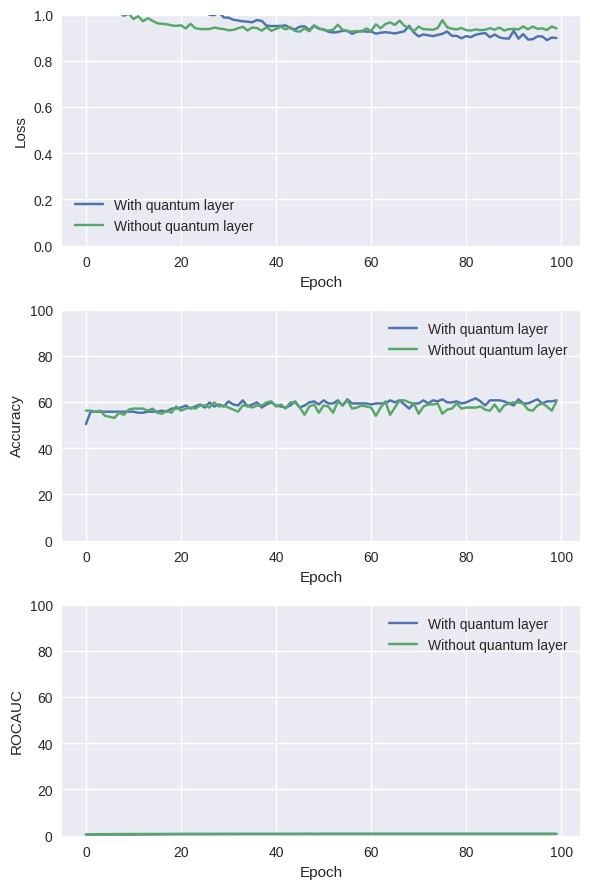

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 63.67%
Normal Model Accuracy: 63.67%
Hybrid Model F1 Score: 0.5608
Normal Model F1 Score: 0.5924
Hybrid Model AUC: 0.7799
Normal Model AUC: 0.8158
Hybrid Model AUPR: 0.4353
Normal Model AUPR: 0.5061


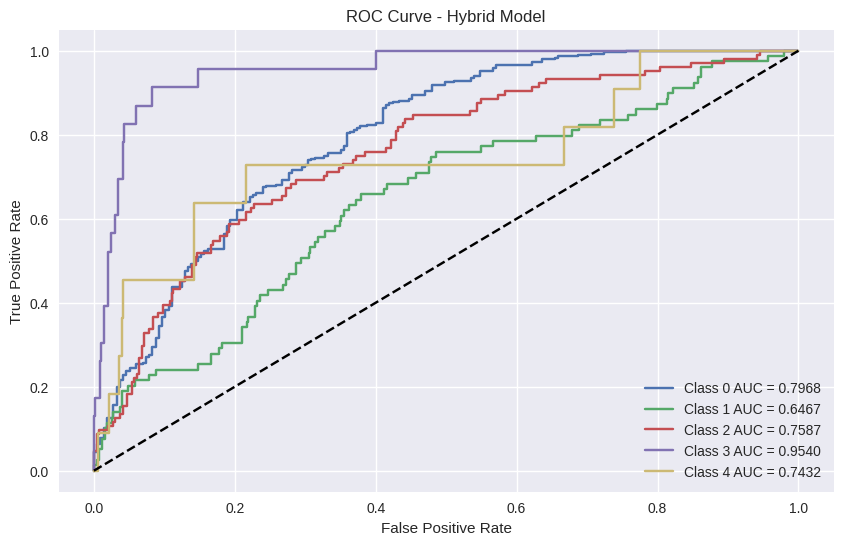

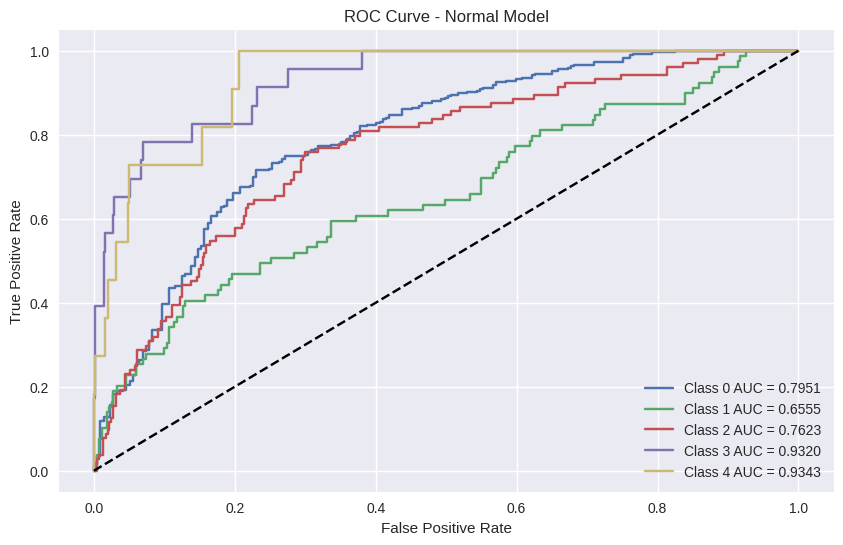

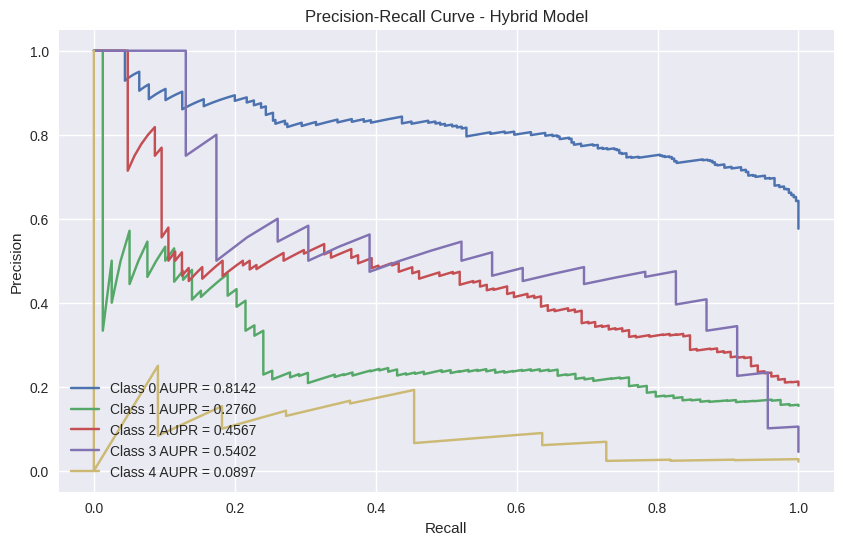

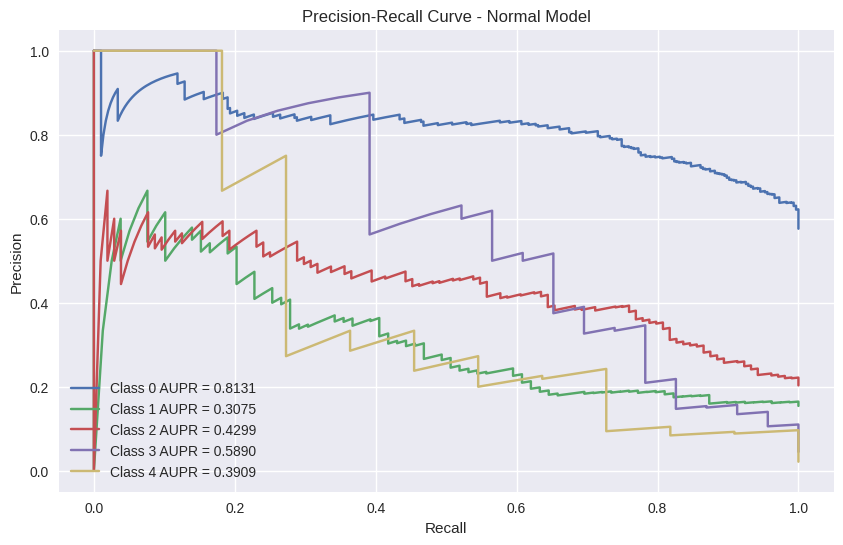

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 2

In [ ]:
seed = 42
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5885, Training Accuracy: 23.54%, Training AUROC: 0.5362
Validation Loss: 1.3079, Validation Accuracy: 44.20%, Validation AUROC: 0.5304
Epoch [2/100]
Training Loss: 1.2103, Training Accuracy: 57.19%, Training AUROC: 0.5190
Validation Loss: 1.0958, Validation Accuracy: 54.46%, Validation AUROC: 0.5584
Epoch [3/100]
Training Loss: 1.1246, Training Accuracy: 58.54%, Training AUROC: 0.5522
Validation Loss: 1.0704, Validation Accuracy: 54.46%, Validation AUROC: 0.5820
Epoch [4/100]
Training Loss: 1.0985, Training Accuracy: 58.65%, Training AUROC: 0.6038
Validation Loss: 1.0651, Validation Accuracy: 53.57%, Validation AUROC: 0.6082
Epoch [5/100]
Training Loss: 1.0786, Training Accuracy: 58.23%, Training AUROC: 0.6322
Validation Loss: 1.0426, Validation Accuracy: 54.02%, Validation AUROC: 0.6434
Epoch [6/100]
Training Loss: 1.0621, Training Accuracy: 59.06%, Training AUROC: 0.6694
Validation Loss: 1.0303, Validation Accuracy: 54.91%, Validation AUROC: 0.6751
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.3927, Training Accuracy: 55.00%, Training AUROC: 0.5226
Validation Loss: 1.2787, Validation Accuracy: 55.80%, Validation AUROC: 0.5043
Epoch [2/100]
Training Loss: 1.3268, Training Accuracy: 58.75%, Training AUROC: 0.5479
Validation Loss: 1.2445, Validation Accuracy: 55.80%, Validation AUROC: 0.5393
Epoch [3/100]
Training Loss: 1.3013, Training Accuracy: 58.44%, Training AUROC: 0.5603
Validation Loss: 1.2269, Validation Accuracy: 55.80%, Validation AUROC: 0.5671
Epoch [4/100]
Training Loss: 1.2880, Training Accuracy: 58.23%, Training AUROC: 0.5861
Validation Loss: 1.2083, Validation Accuracy: 55.80%, Validation AUROC: 0.5830
Epoch [5/100]
Training Loss: 1.2645, Training Accuracy: 58.23%, Training AUROC: 0.6082
Validation Loss: 1.1892, Validation Accuracy: 55.80%, Validation AUROC: 0.6151
Epoch [6/100]
Training Loss: 1.2430, Training Accuracy: 58.54%, Training AUROC: 0.6255
Validation Loss: 1.1743, Validation Accuracy: 55.80%, Validation AUROC: 0.6228
Epoc

<ipython-input-17-719a34750af0>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


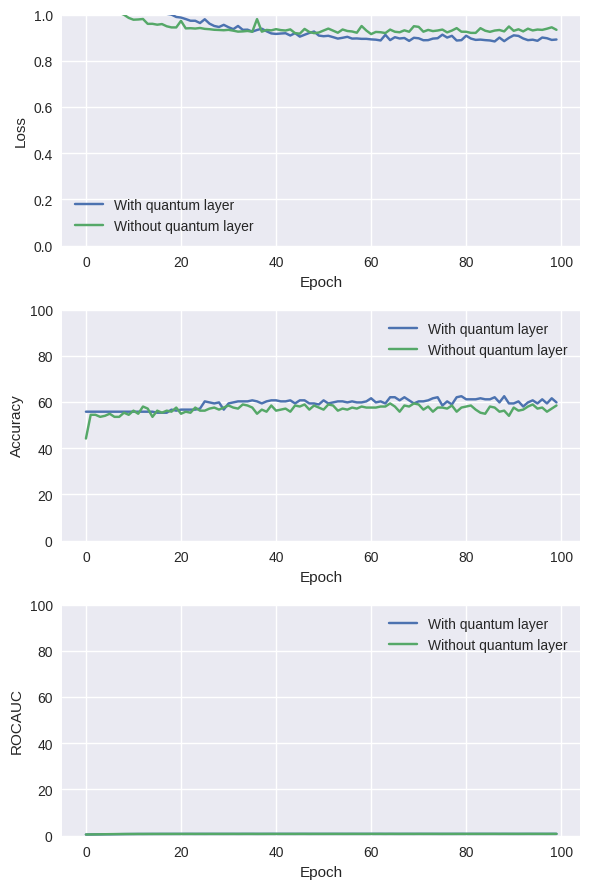

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 63.67%
Normal Model Accuracy: 63.67%
Hybrid Model F1 Score: 0.5843
Normal Model F1 Score: 0.6061
Hybrid Model AUC: 0.8030
Normal Model AUC: 0.8114
Hybrid Model AUPR: 0.4230
Normal Model AUPR: 0.4941


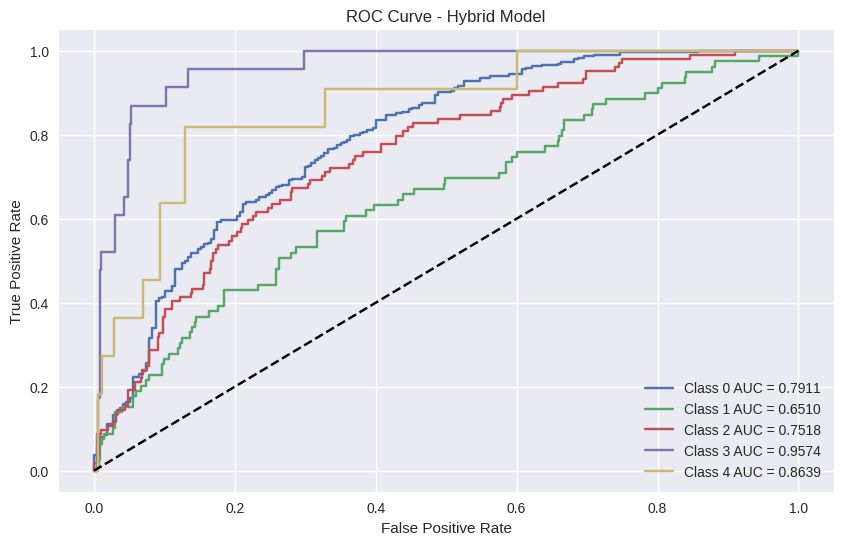

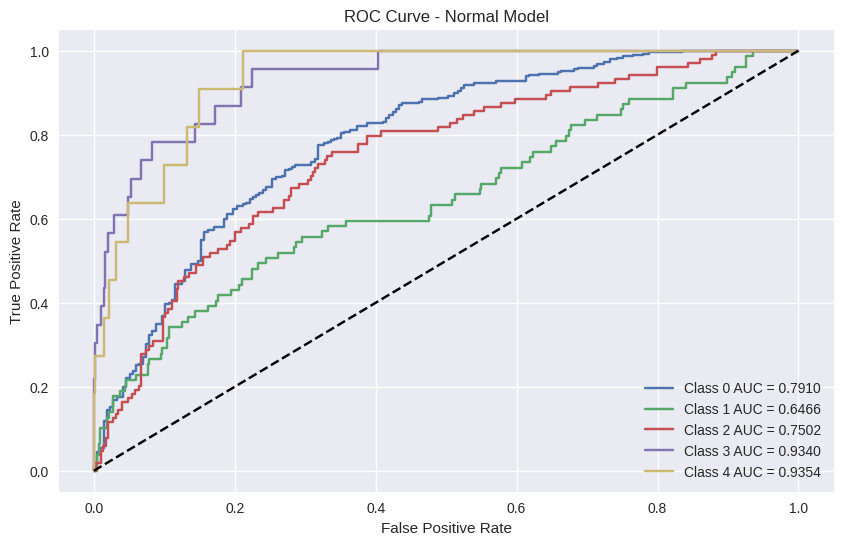

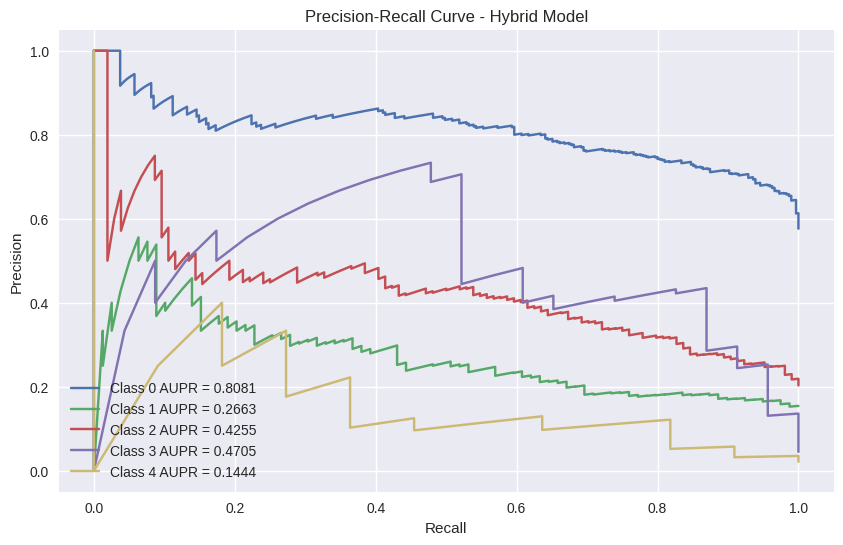

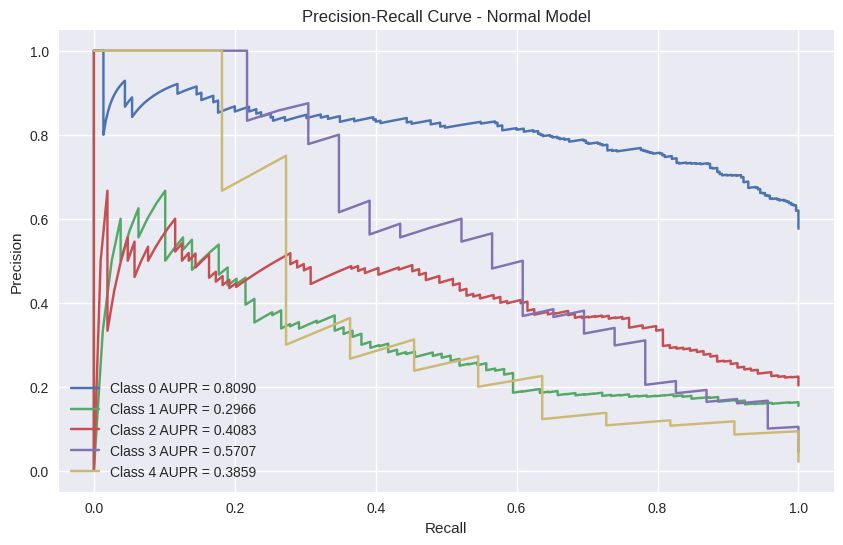

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 3

In [ ]:
seed = 5923
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 227MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4440, Training Accuracy: 44.79%, Training AUROC: 0.4843
Validation Loss: 1.1872, Validation Accuracy: 54.46%, Validation AUROC: 0.5362
Epoch [2/100]
Training Loss: 1.2129, Training Accuracy: 58.13%, Training AUROC: 0.4682
Validation Loss: 1.1033, Validation Accuracy: 55.80%, Validation AUROC: 0.5700
Epoch [3/100]
Training Loss: 1.1737, Training Accuracy: 58.33%, Training AUROC: 0.4618
Validation Loss: 1.0937, Validation Accuracy: 55.80%, Validation AUROC: 0.5795
Epoch [4/100]
Training Loss: 1.1628, Training Accuracy: 58.44%, Training AUROC: 0.4643
Validation Loss: 1.0887, Validation Accuracy: 55.80%, Validation AUROC: 0.5833
Epoch [5/100]
Training Loss: 1.1561, Training Accuracy: 58.33%, Training AUROC: 0.4989
Validation Loss: 1.0832, Validation Accuracy: 55.80%, Validation AUROC: 0.5886
Epoch [6/100]
Training Loss: 1.1501, Training Accuracy: 58.33%, Training AUROC: 0.4790
Validation Loss: 1.0777, Validation Accuracy: 55.80%, Validation AUROC: 0.5717
Epoc

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

In [ ]:
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/quantum_hybrid_model_5923.pth", weights_only=False)
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/normal_model_5923.pth", weights_only=False)

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 4

In [ ]:
seed = 8932
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5032, Training Accuracy: 32.81%, Training AUROC: 0.4980
Validation Loss: 1.2388, Validation Accuracy: 47.77%, Validation AUROC: 0.5348
Epoch [2/100]
Training Loss: 1.1796, Training Accuracy: 59.27%, Training AUROC: 0.5285
Validation Loss: 1.0924, Validation Accuracy: 55.36%, Validation AUROC: 0.5760
Epoch [3/100]
Training Loss: 1.1223, Training Accuracy: 58.54%, Training AUROC: 0.5571
Validation Loss: 1.0657, Validation Accuracy: 53.57%, Validation AUROC: 0.6043
Epoch [4/100]
Training Loss: 1.0931, Training Accuracy: 59.58%, Training AUROC: 0.5812
Validation Loss: 1.0506, Validation Accuracy: 52.68%, Validation AUROC: 0.6289
Epoch [5/100]
Training Loss: 1.0741, Training Accuracy: 59.79%, Training AUROC: 0.6110
Validation Loss: 1.0331, Validation Accuracy: 52.23%, Validation AUROC: 0.6588
Epoch [6/100]
Training Loss: 1.0437, Training Accuracy: 60.00%, Training AUROC: 0.6731
Validation Loss: 1.0212, Validation Accuracy: 52.68%, Validation AUROC: 0.6871
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4942, Training Accuracy: 20.62%, Training AUROC: 0.4929
Validation Loss: 1.3476, Validation Accuracy: 39.73%, Validation AUROC: 0.4571
Epoch [2/100]
Training Loss: 1.3709, Training Accuracy: 48.75%, Training AUROC: 0.5208
Validation Loss: 1.2046, Validation Accuracy: 56.25%, Validation AUROC: 0.5151
Epoch [3/100]
Training Loss: 1.2686, Training Accuracy: 58.02%, Training AUROC: 0.5435
Validation Loss: 1.1830, Validation Accuracy: 55.80%, Validation AUROC: 0.5267
Epoch [4/100]
Training Loss: 1.2537, Training Accuracy: 58.33%, Training AUROC: 0.5429
Validation Loss: 1.1736, Validation Accuracy: 55.80%, Validation AUROC: 0.5320
Epoch [5/100]
Training Loss: 1.2407, Training Accuracy: 58.33%, Training AUROC: 0.5600
Validation Loss: 1.1626, Validation Accuracy: 55.80%, Validation AUROC: 0.5432
Epoch [6/100]
Training Loss: 1.2228, Training Accuracy: 58.54%, Training AUROC: 0.5737
Validation Loss: 1.1497, Validation Accuracy: 55.36%, Validation AUROC: 0.5553
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


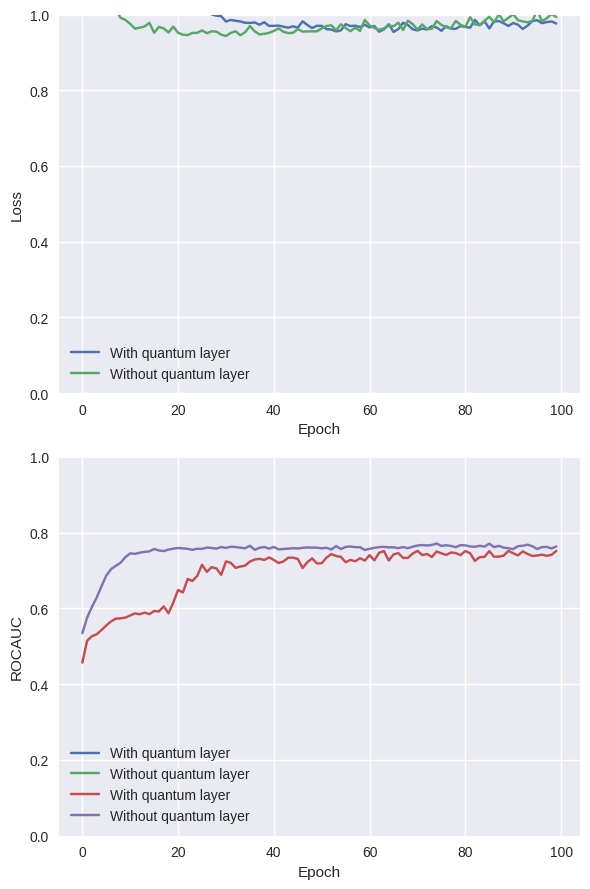

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 62.50%
Normal Model Accuracy: 63.48%
Hybrid Model F1 Score: 0.5695
Normal Model F1 Score: 0.5948
Hybrid Model AUC: 0.7702
Normal Model AUC: 0.8117
Hybrid Model AUPR: 0.4106
Normal Model AUPR: 0.5105


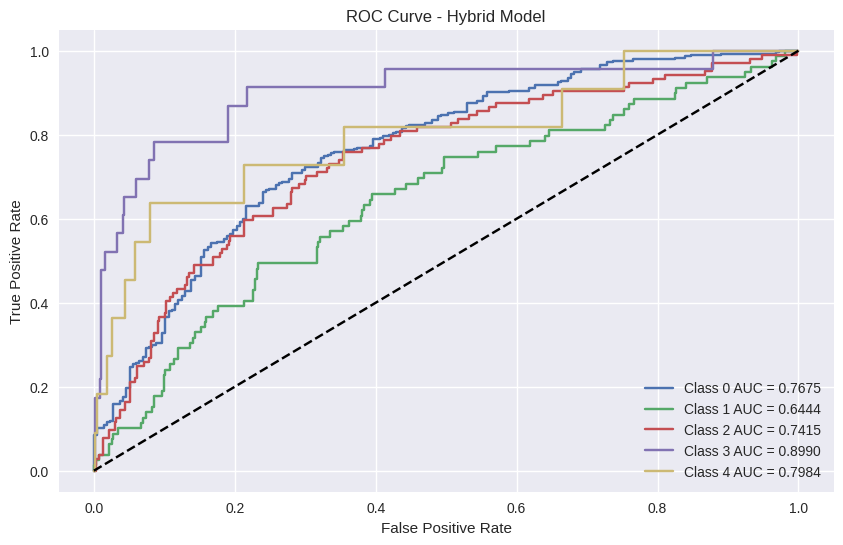

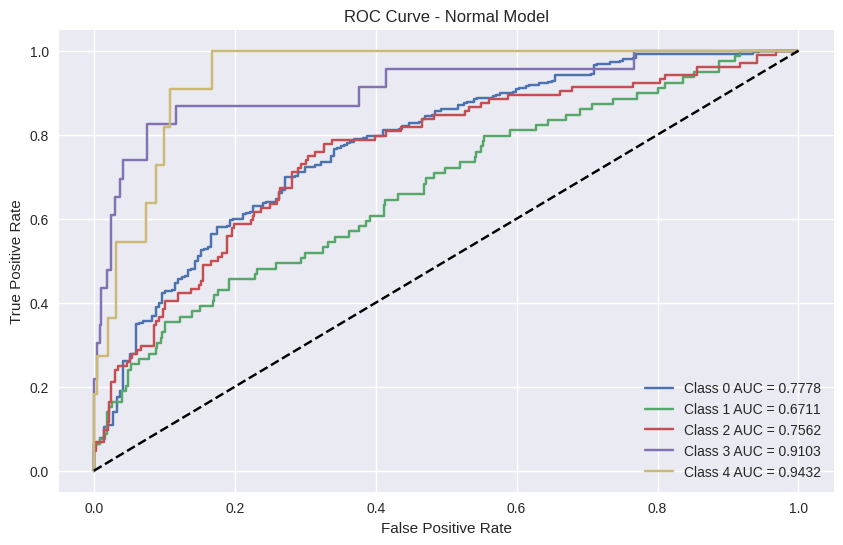

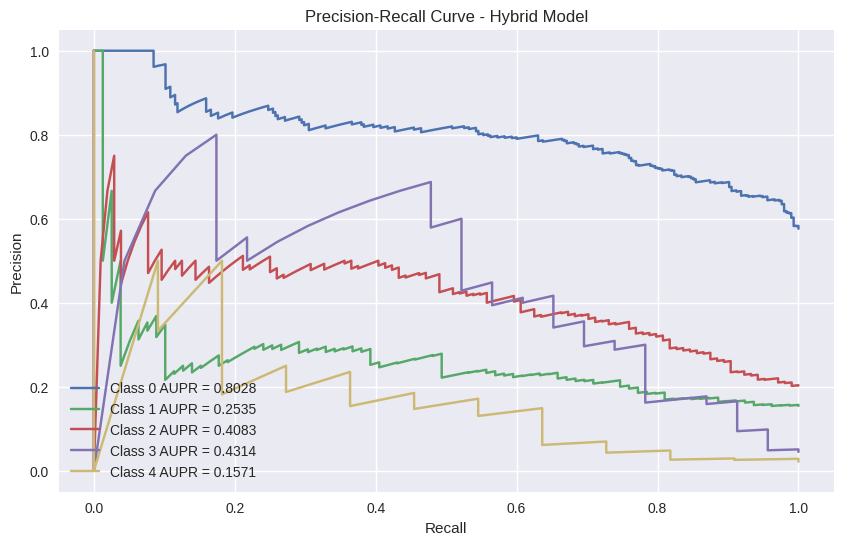

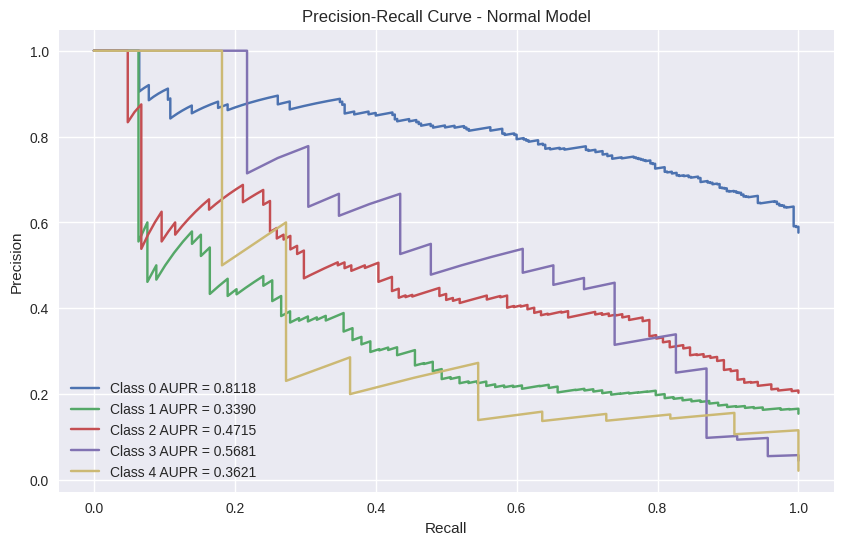

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

Seed Experiments 5

In [ ]:
seed = 56
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5565, Training Accuracy: 23.75%, Training AUROC: 0.5518
Validation Loss: 1.2265, Validation Accuracy: 42.86%, Validation AUROC: 0.5958
Epoch [2/100]
Training Loss: 1.1908, Training Accuracy: 56.15%, Training AUROC: 0.5437
Validation Loss: 1.0648, Validation Accuracy: 55.80%, Validation AUROC: 0.6410
Epoch [3/100]
Training Loss: 1.1224, Training Accuracy: 58.65%, Training AUROC: 0.5859
Validation Loss: 1.0395, Validation Accuracy: 55.80%, Validation AUROC: 0.6694
Epoch [4/100]
Training Loss: 1.1068, Training Accuracy: 58.23%, Training AUROC: 0.6082
Validation Loss: 1.0247, Validation Accuracy: 55.80%, Validation AUROC: 0.6984
Epoch [5/100]
Training Loss: 1.0856, Training Accuracy: 58.44%, Training AUROC: 0.6389
Validation Loss: 1.0141, Validation Accuracy: 55.80%, Validation AUROC: 0.7176
Epoch [6/100]
Training Loss: 1.0623, Training Accuracy: 58.23%, Training AUROC: 0.6873
Validation Loss: 0.9904, Validation Accuracy: 56.25%, Validation AUROC: 0.7376
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.2617, Training Accuracy: 58.13%, Training AUROC: 0.5588
Validation Loss: 1.1830, Validation Accuracy: 55.80%, Validation AUROC: 0.5724
Epoch [2/100]
Training Loss: 1.2388, Training Accuracy: 58.13%, Training AUROC: 0.5384
Validation Loss: 1.1651, Validation Accuracy: 55.80%, Validation AUROC: 0.5689
Epoch [3/100]
Training Loss: 1.2239, Training Accuracy: 58.33%, Training AUROC: 0.5252
Validation Loss: 1.1558, Validation Accuracy: 55.80%, Validation AUROC: 0.5703
Epoch [4/100]
Training Loss: 1.2078, Training Accuracy: 58.54%, Training AUROC: 0.5661
Validation Loss: 1.1433, Validation Accuracy: 55.80%, Validation AUROC: 0.5639
Epoch [5/100]
Training Loss: 1.1971, Training Accuracy: 58.33%, Training AUROC: 0.5757
Validation Loss: 1.1313, Validation Accuracy: 55.80%, Validation AUROC: 0.5761
Epoch [6/100]
Training Loss: 1.1788, Training Accuracy: 58.33%, Training AUROC: 0.5885
Validation Loss: 1.1196, Validation Accuracy: 55.80%, Validation AUROC: 0.5848
Epoc

<ipython-input-17-719a34750af0>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


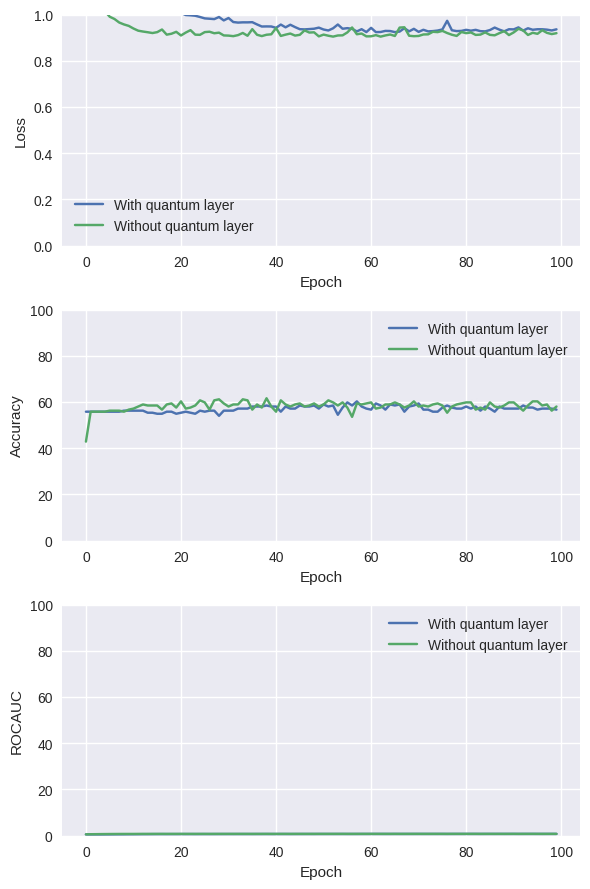

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 63.09%
Normal Model Accuracy: 63.87%
Hybrid Model F1 Score: 0.5929
Normal Model F1 Score: 0.6121
Hybrid Model AUC: 0.7987
Normal Model AUC: 0.8142
Hybrid Model AUPR: 0.4291
Normal Model AUPR: 0.4913


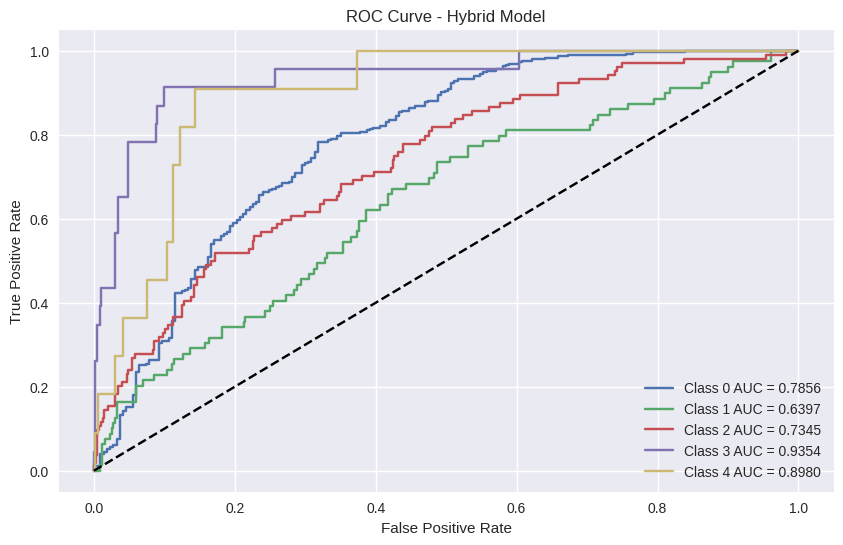

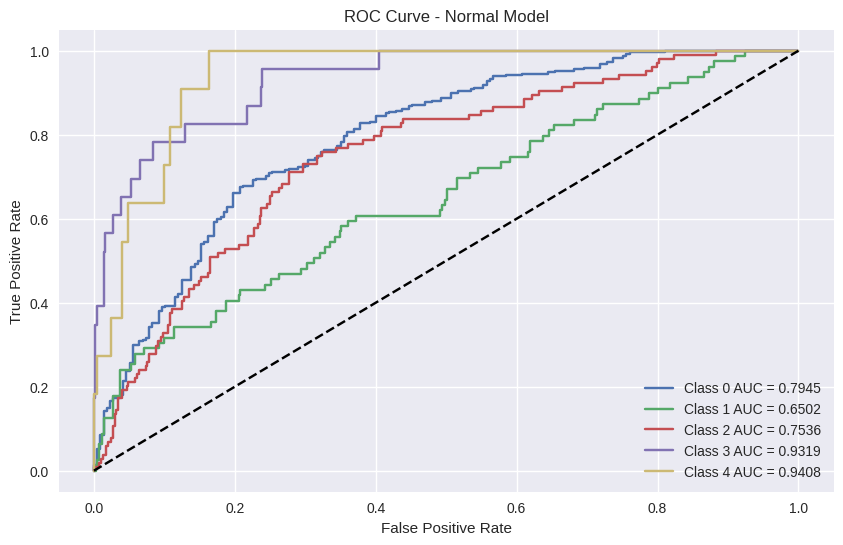

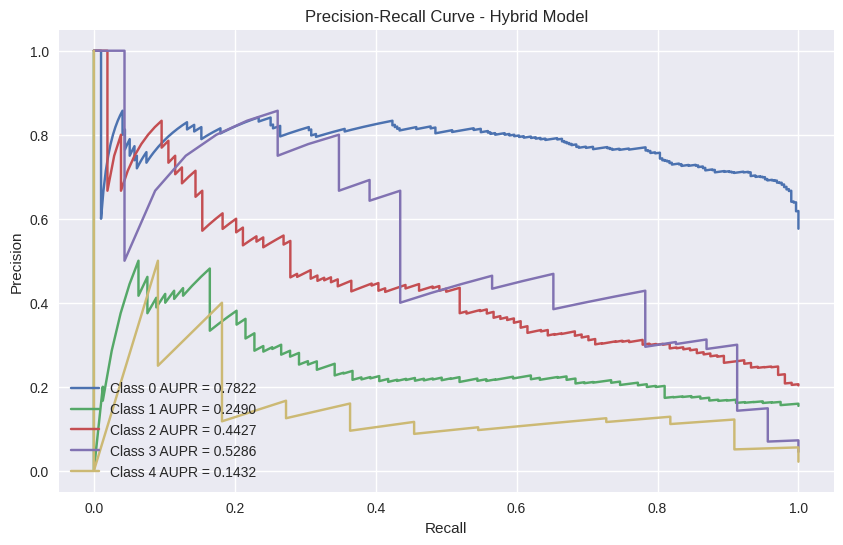

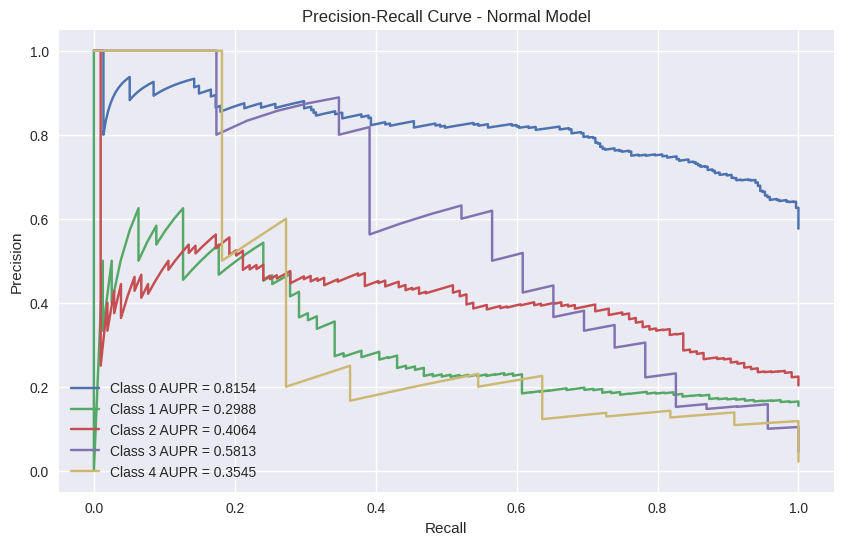

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

# Experimenting Messidor on IDRID and APTOS

## Experimenting Messidor on IDRID

In [ ]:
batch_size = 32
dataset = "IDRID"
num_classes=5
q_depth = 4

In [ ]:
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)

### Testing Model From Seed 1

Hybrid Model Accuracy: 42.19%
Normal Model Accuracy: 56.25%
Hybrid Model F1 Score: 0.3352
Normal Model F1 Score: 0.5231
Hybrid Model AUC: 0.7425
Normal Model AUC: 0.8000
Hybrid Model AUPR: 0.3841
Normal Model AUPR: 0.4457


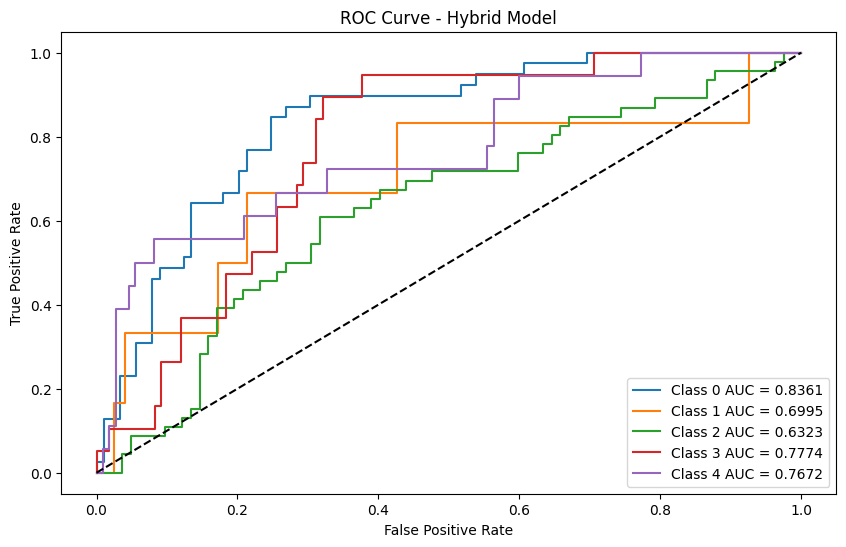

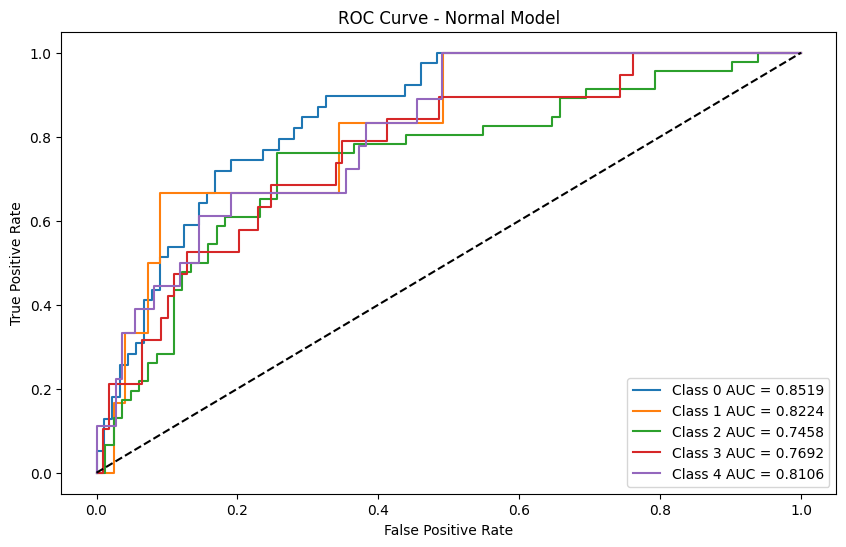

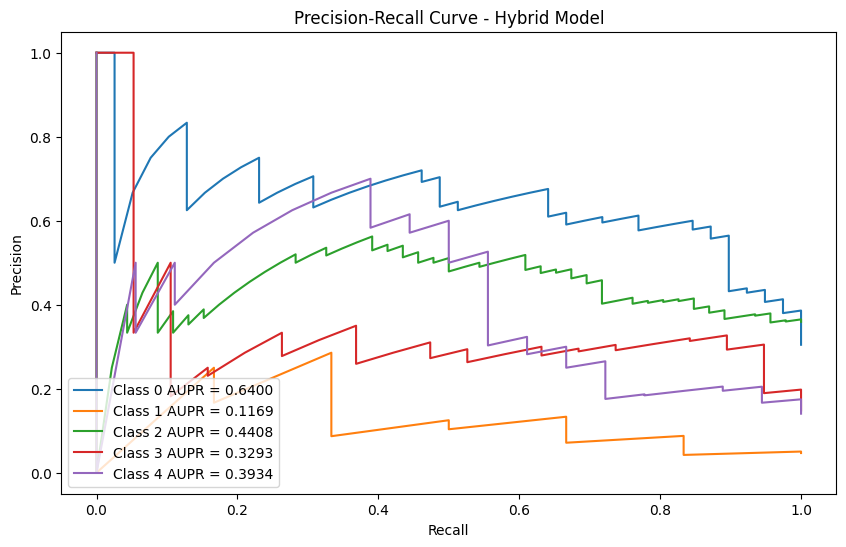

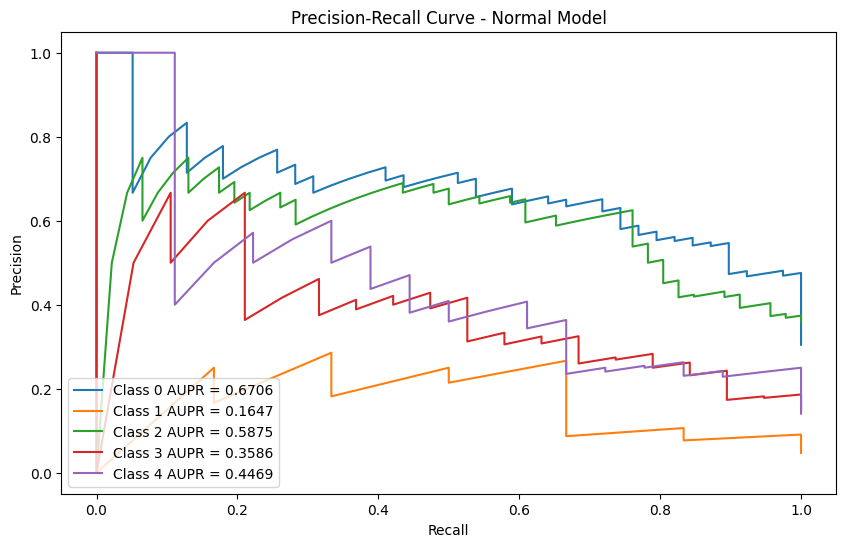

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/normal_model_0.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/quantum_hybrid_model_0.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 2

Hybrid Model Accuracy: 47.66%
Normal Model Accuracy: 55.47%
Hybrid Model F1 Score: 0.3962
Normal Model F1 Score: 0.5101
Hybrid Model AUC: 0.7315
Normal Model AUC: 0.7959
Hybrid Model AUPR: 0.3659
Normal Model AUPR: 0.4545


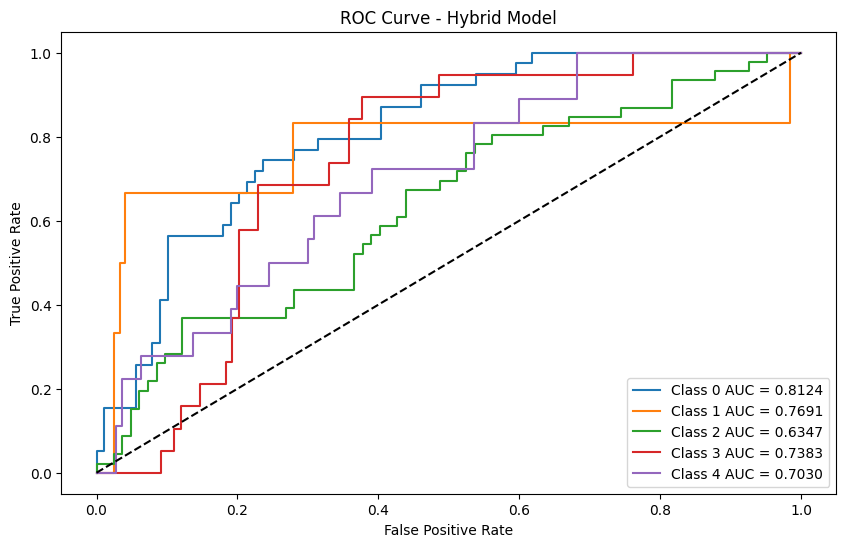

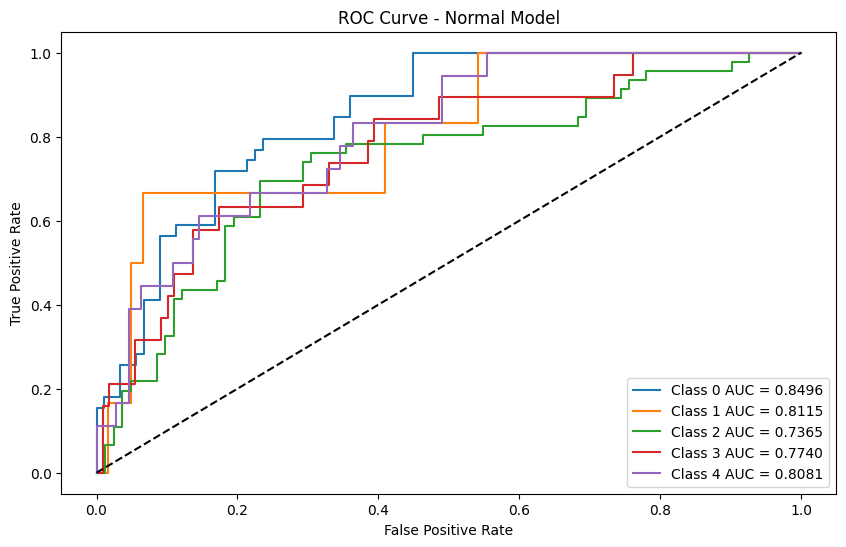

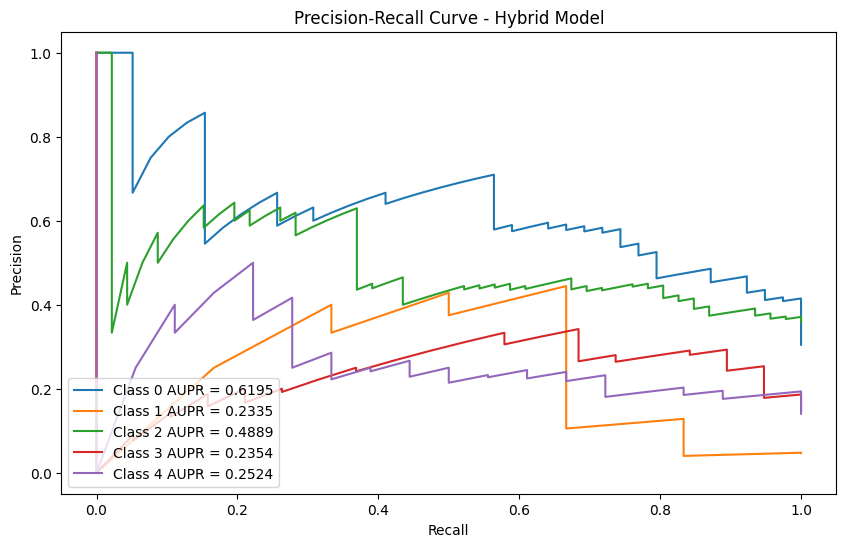

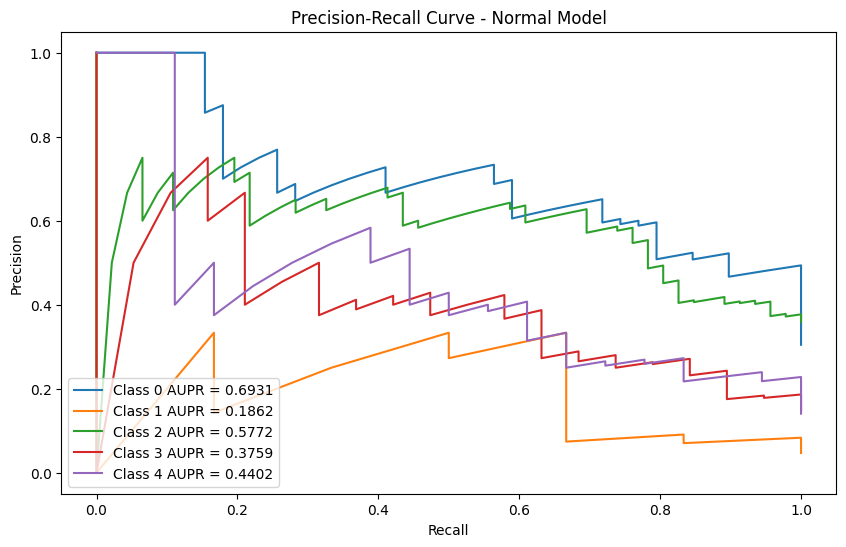

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/normal_model_42.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/quantum_hybrid_model_42.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 3

Hybrid Model Accuracy: 42.97%
Normal Model Accuracy: 53.12%
Hybrid Model F1 Score: 0.3744
Normal Model F1 Score: 0.4709
Hybrid Model AUC: 0.7492
Normal Model AUC: 0.7917
Hybrid Model AUPR: 0.4028
Normal Model AUPR: 0.4398


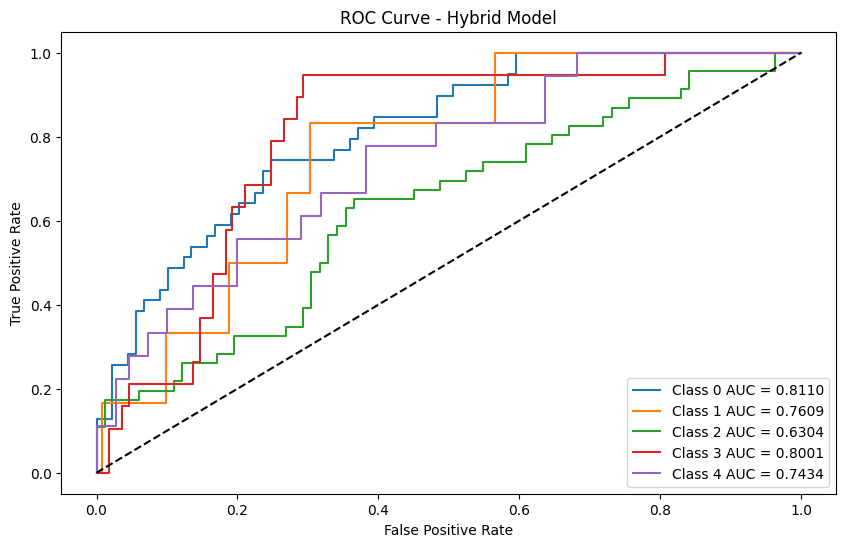

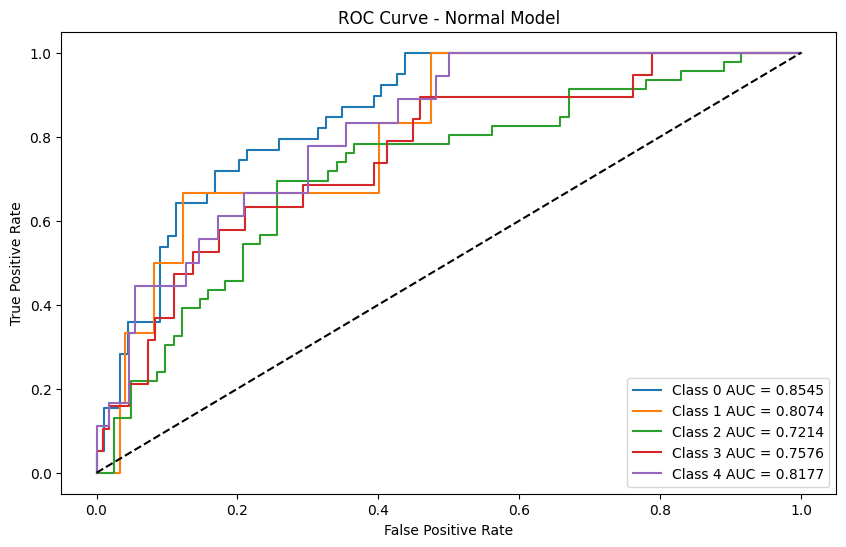

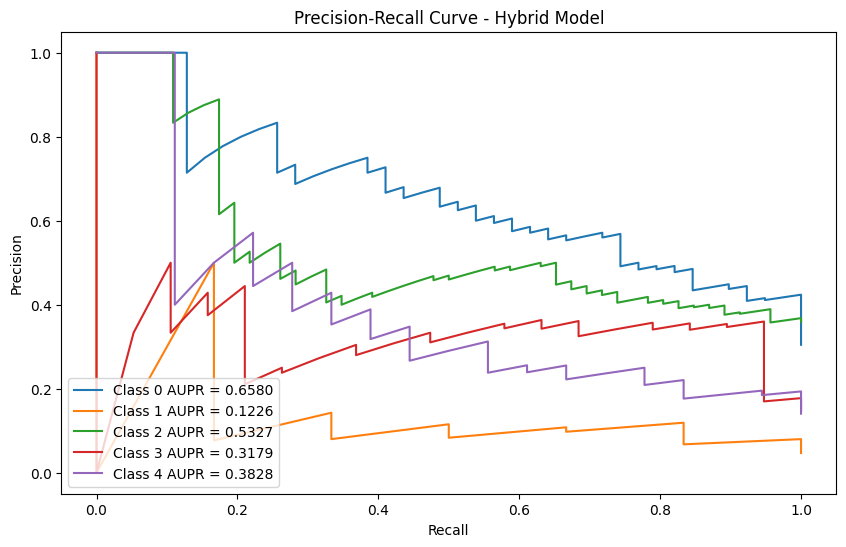

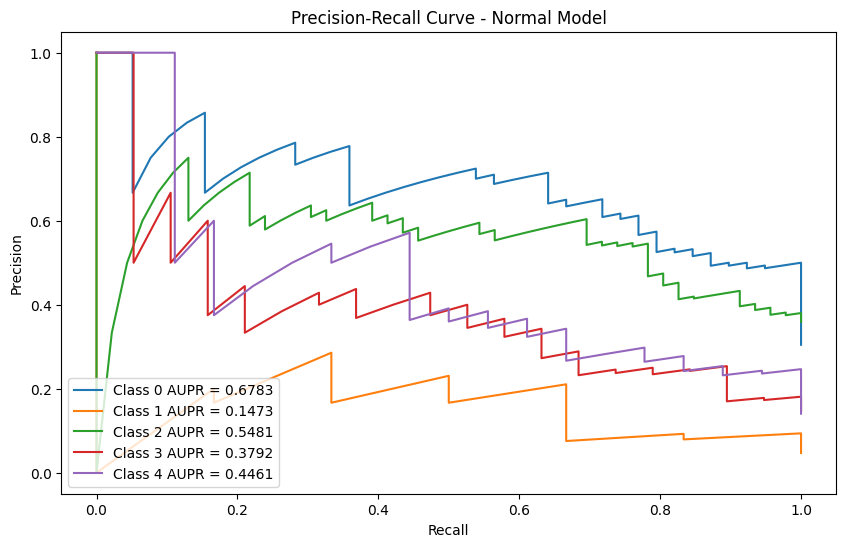

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/normal_model_56.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/quantum_hybrid_model_56.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 4

Hybrid Model Accuracy: 48.44%
Normal Model Accuracy: 55.47%
Hybrid Model F1 Score: 0.4351
Normal Model F1 Score: 0.5172
Hybrid Model AUC: 0.7550
Normal Model AUC: 0.7957
Hybrid Model AUPR: 0.4144
Normal Model AUPR: 0.4544


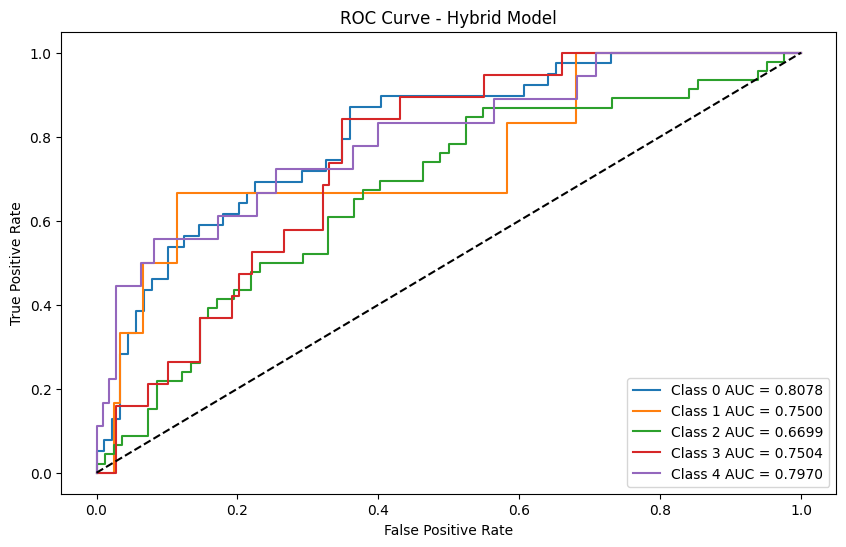

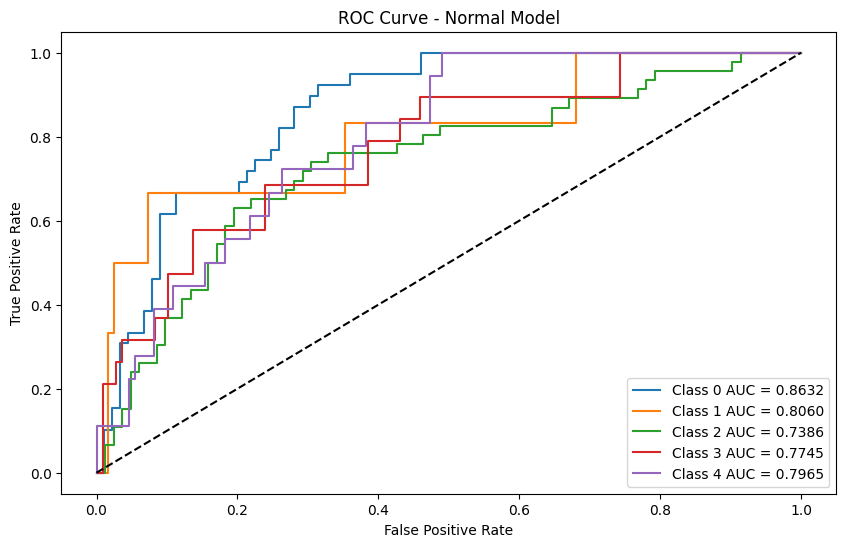

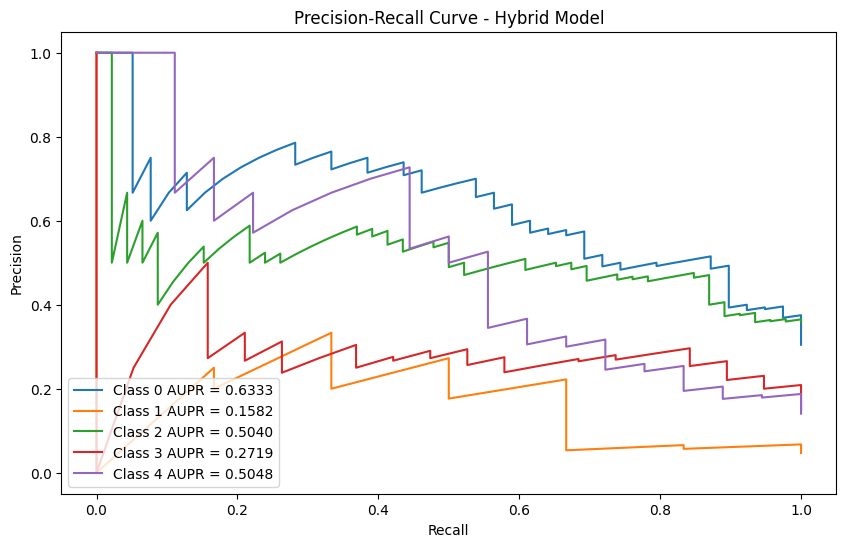

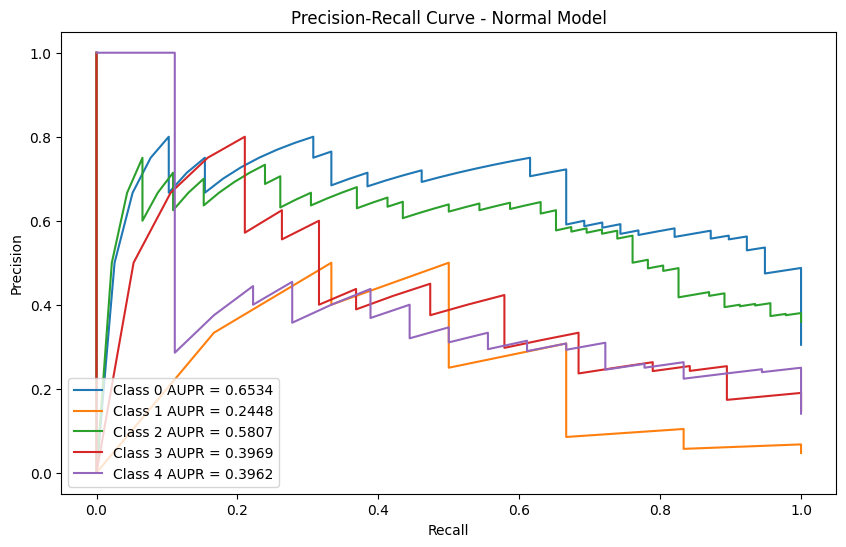

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/normal_model_8932.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/quantum_hybrid_model_8932.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 5

Hybrid Model Accuracy: 46.88%
Normal Model Accuracy: 56.25%
Hybrid Model F1 Score: 0.4121
Normal Model F1 Score: 0.5175
Hybrid Model AUC: 0.7437
Normal Model AUC: 0.7685
Hybrid Model AUPR: 0.3950
Normal Model AUPR: 0.4081


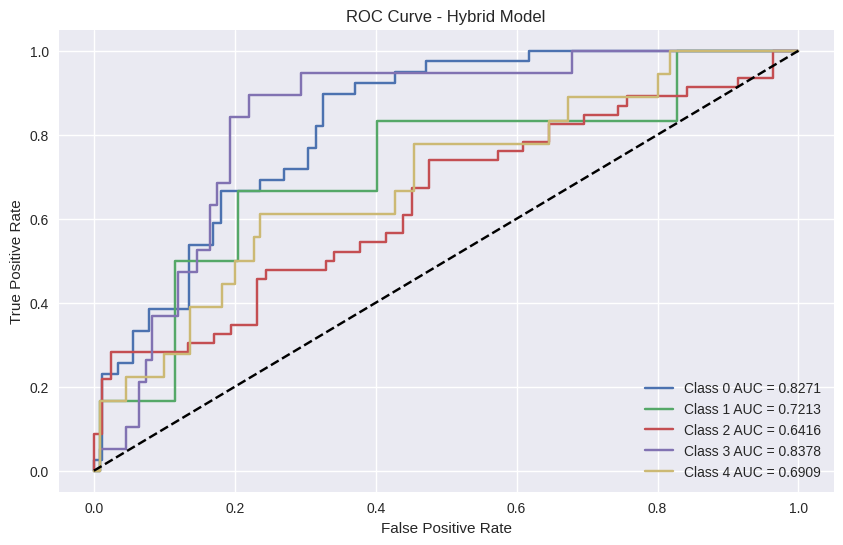

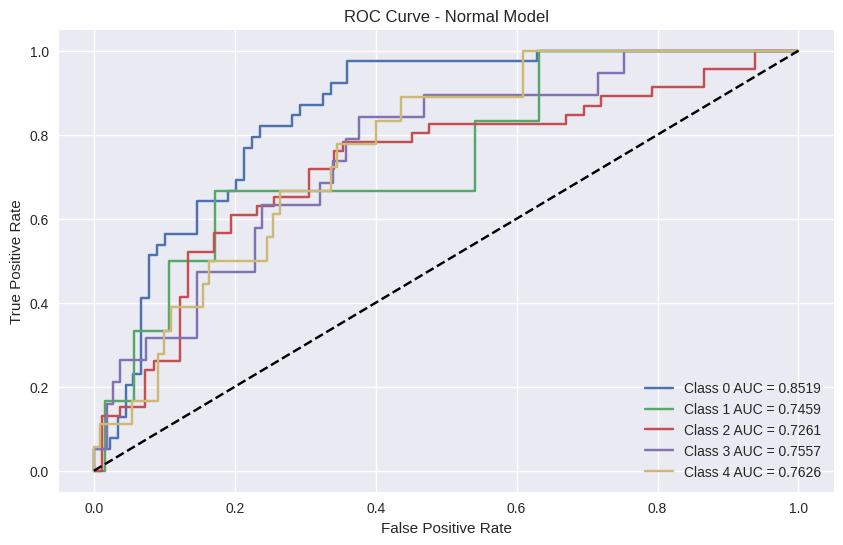

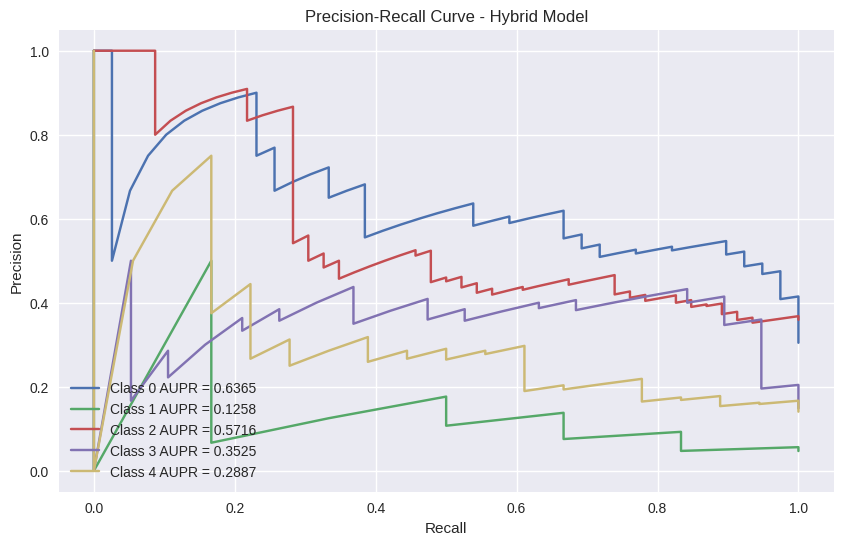

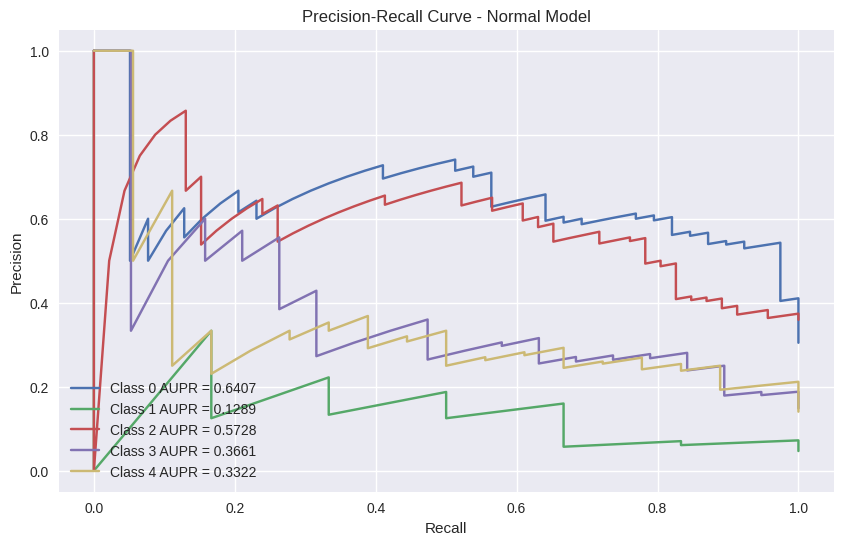

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/normal_model_56.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/quantum_hybrid_model_56.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

## Experimenting Messidor on APTOS

In [ ]:
dataset = "APTOS"
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
num_classes=5
q_depth = 4

### Testing Model From Seed 1

Hybrid Model Accuracy: 77.11%
Normal Model Accuracy: 77.57%
Hybrid Model F1 Score: 0.7475
Normal Model F1 Score: 0.7648
Hybrid Model AUC: 0.8997
Normal Model AUC: 0.9096
Hybrid Model AUPR: 0.5556
Normal Model AUPR: 0.5935


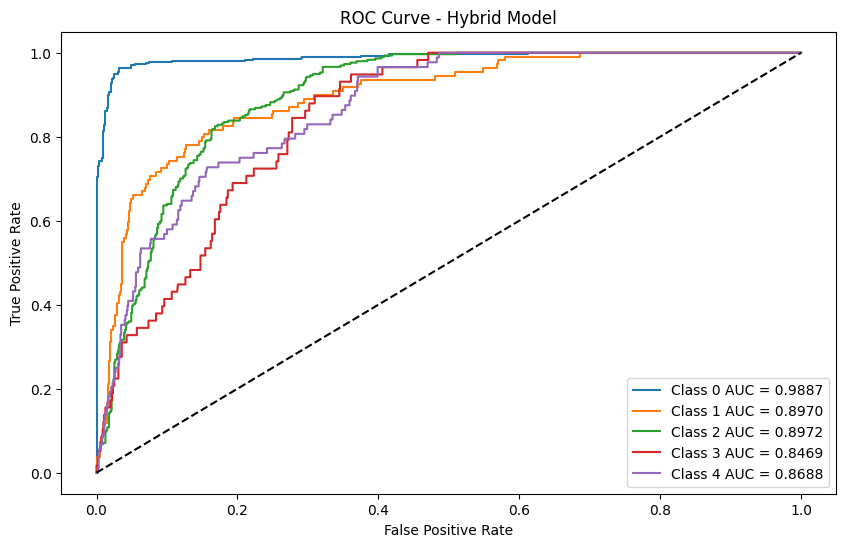

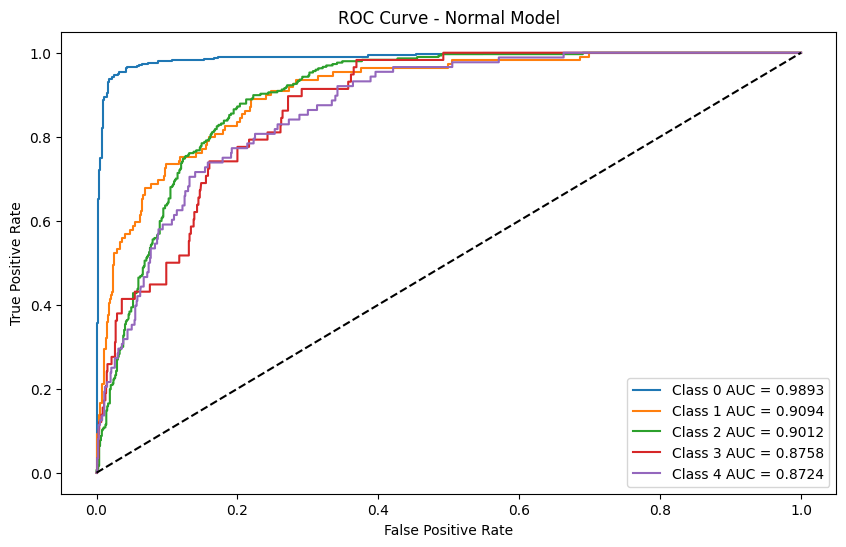

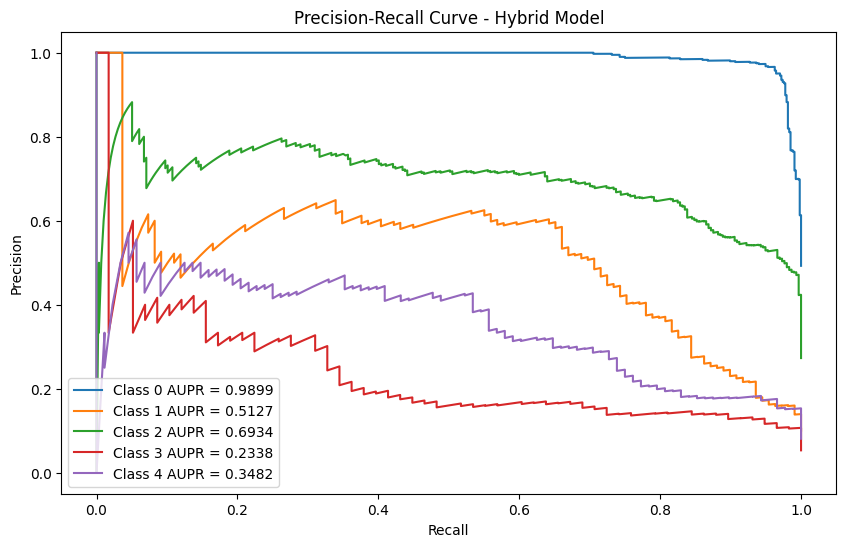

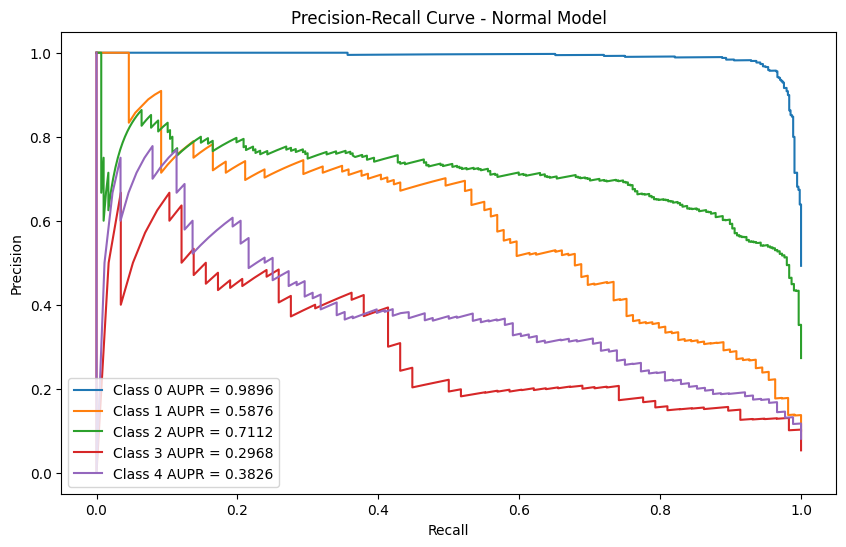

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/normal_model_0.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/quantum_hybrid_model_0.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 2

Hybrid Model Accuracy: 77.39%
Normal Model Accuracy: 77.39%
Hybrid Model F1 Score: 0.7251
Normal Model F1 Score: 0.7648
Hybrid Model AUC: 0.8904
Normal Model AUC: 0.9093
Hybrid Model AUPR: 0.5115
Normal Model AUPR: 0.5906


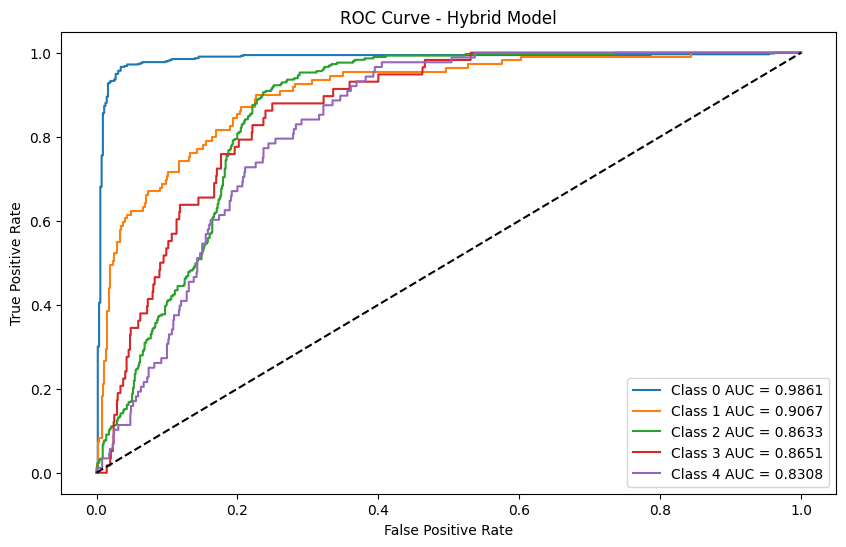

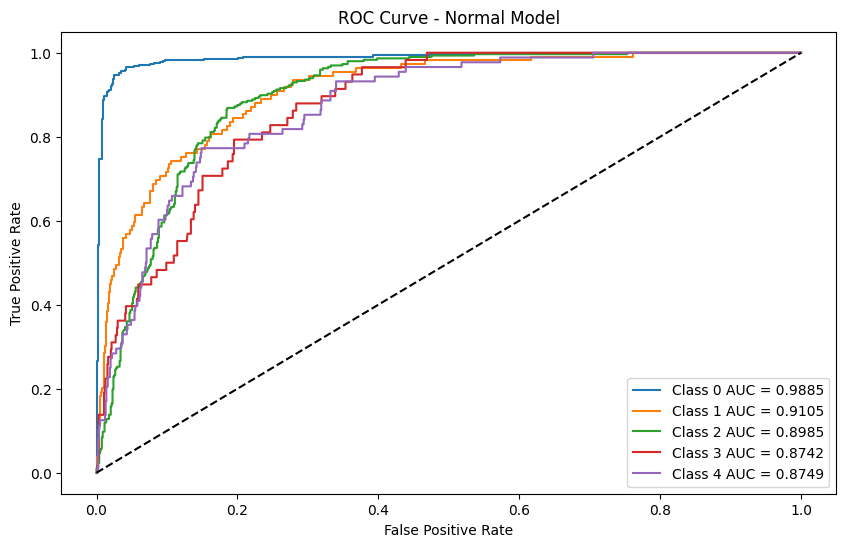

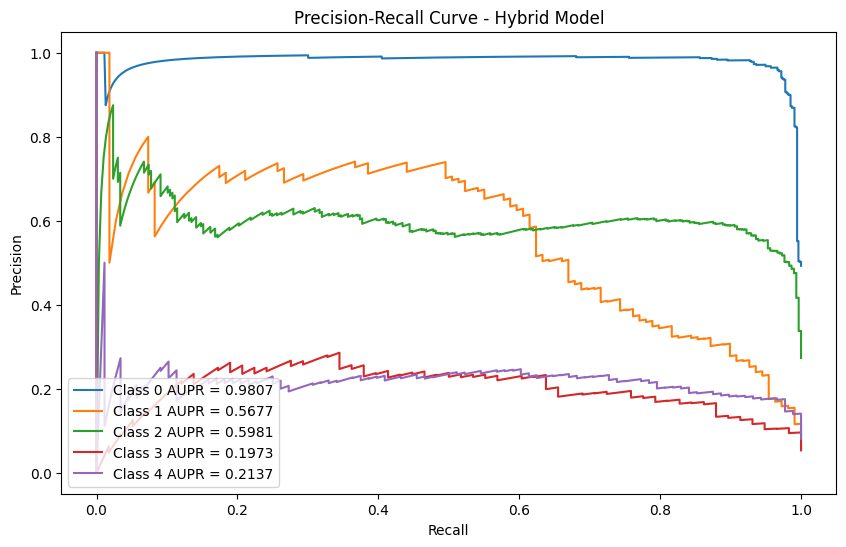

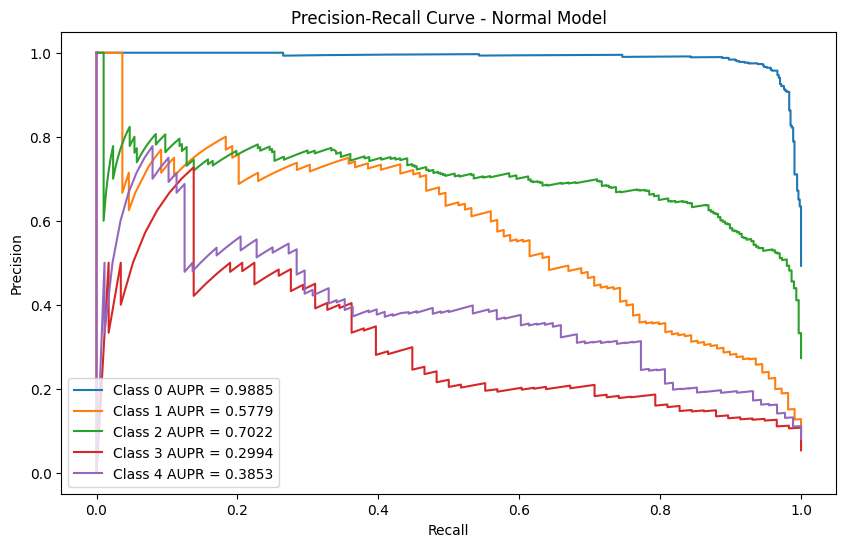

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/normal_model_42.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/quantum_hybrid_model_42.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 3

Hybrid Model Accuracy: 77.11%
Normal Model Accuracy: 78.40%
Hybrid Model F1 Score: 0.7486
Normal Model F1 Score: 0.7654
Hybrid Model AUC: 0.8994
Normal Model AUC: 0.9096
Hybrid Model AUPR: 0.5634
Normal Model AUPR: 0.5952


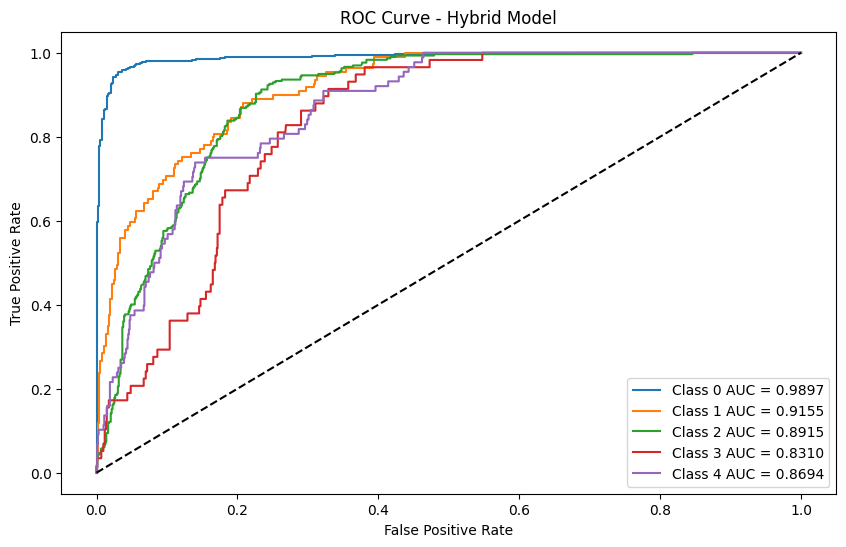

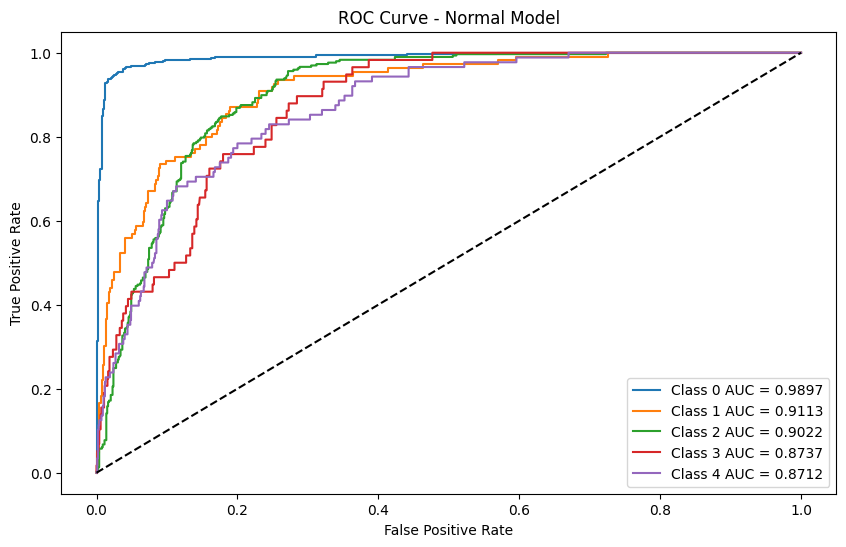

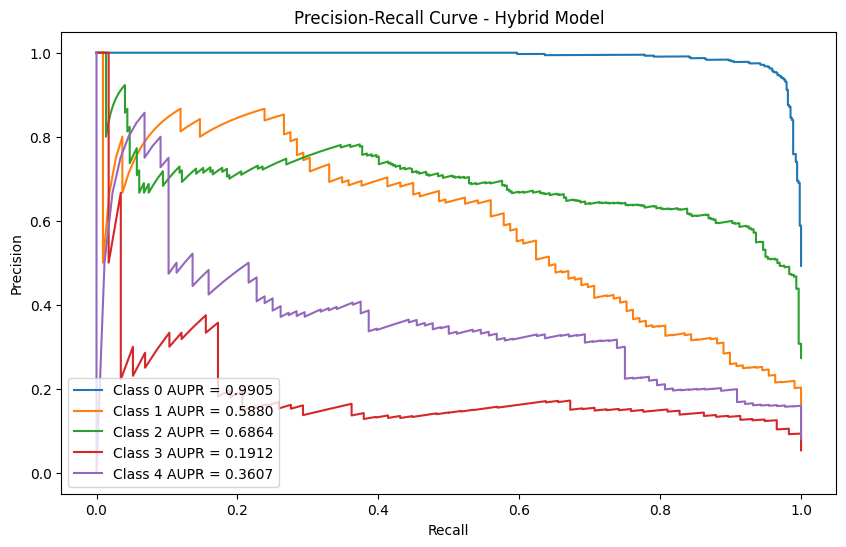

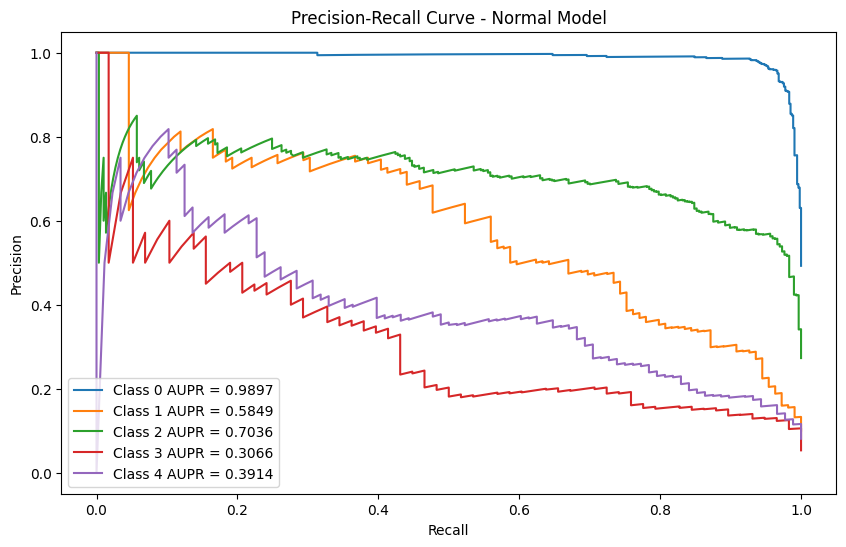

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/normal_model_56.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/quantum_hybrid_model_56.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 4

Hybrid Model Accuracy: 77.94%
Normal Model Accuracy: 76.93%
Hybrid Model F1 Score: 0.7637
Normal Model F1 Score: 0.7609
Hybrid Model AUC: 0.9026
Normal Model AUC: 0.9081
Hybrid Model AUPR: 0.5683
Normal Model AUPR: 0.5840


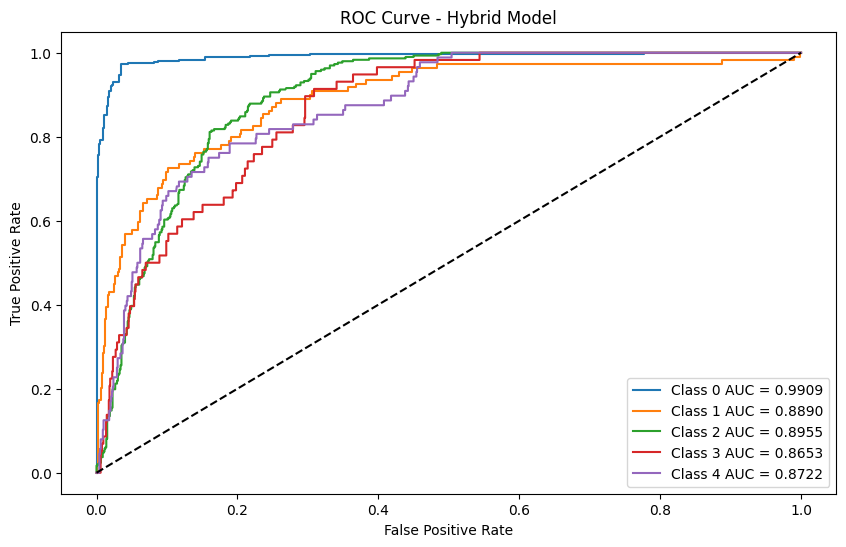

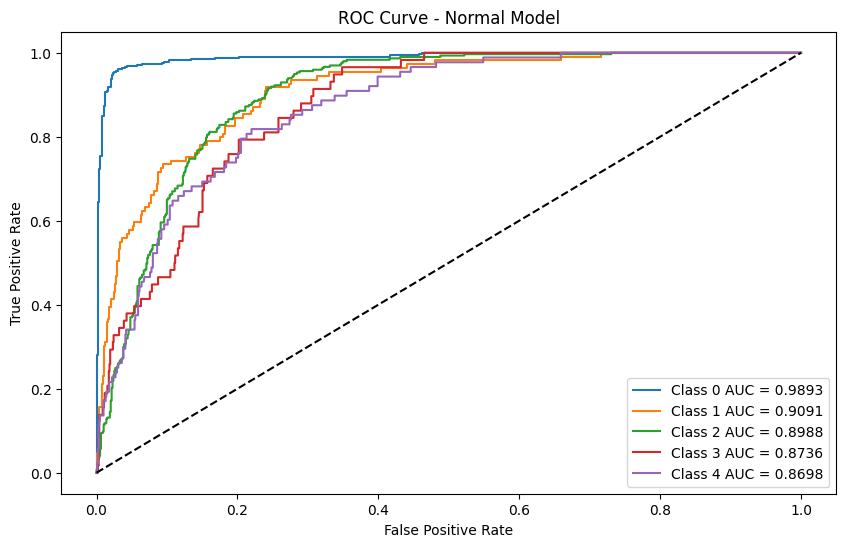

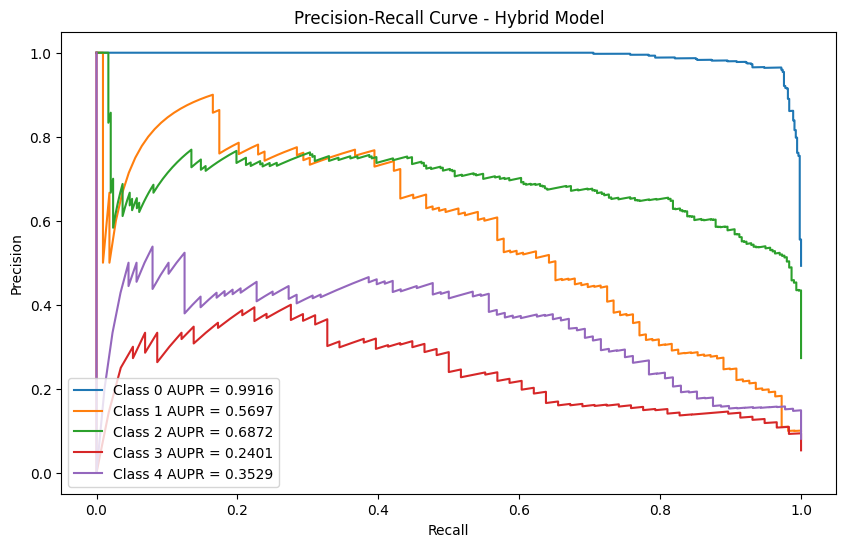

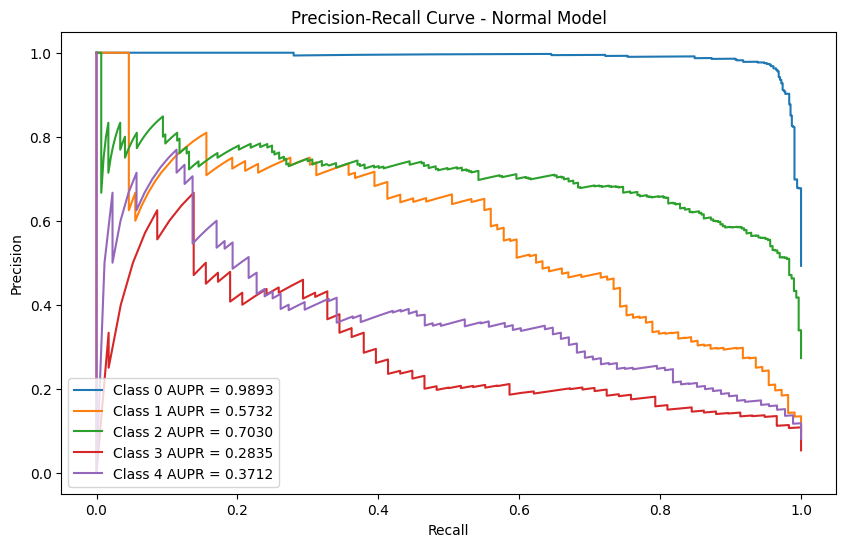

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/normal_model_8932.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/quantum_hybrid_model_8932.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 5

Hybrid Model Accuracy: 74.09%
Normal Model Accuracy: 73.18%
Hybrid Model F1 Score: 0.7111
Normal Model F1 Score: 0.7036
Hybrid Model AUC: 0.8789
Normal Model AUC: 0.8736
Hybrid Model AUPR: 0.5132
Normal Model AUPR: 0.5048


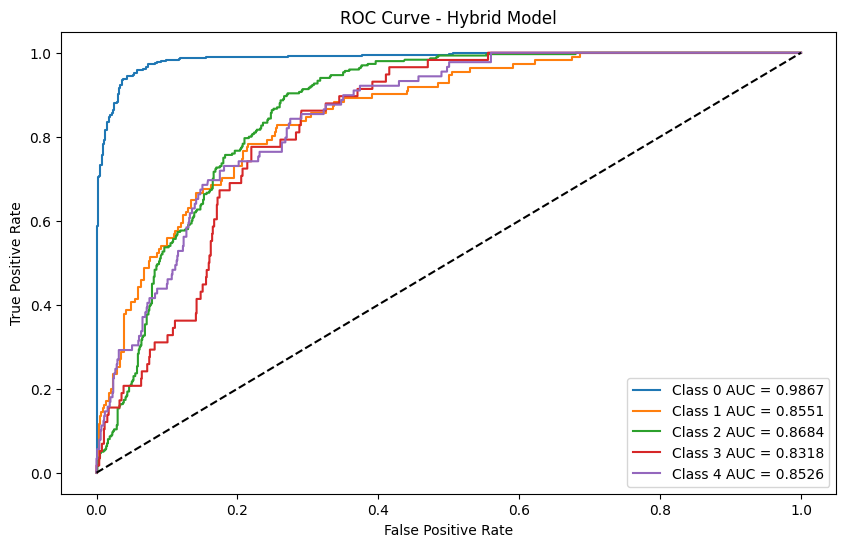

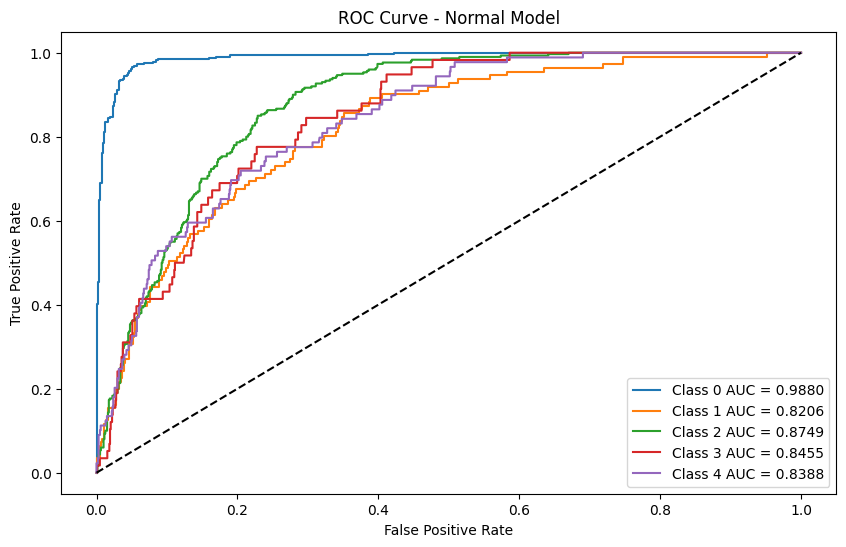

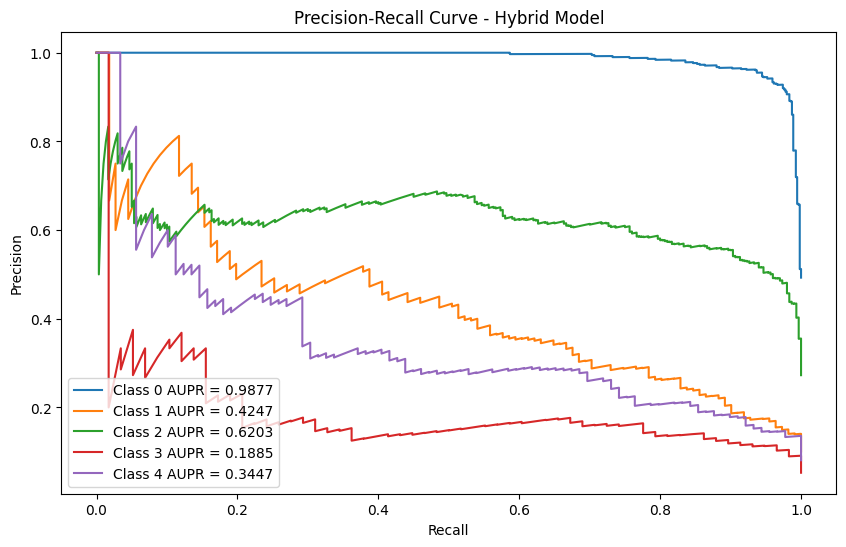

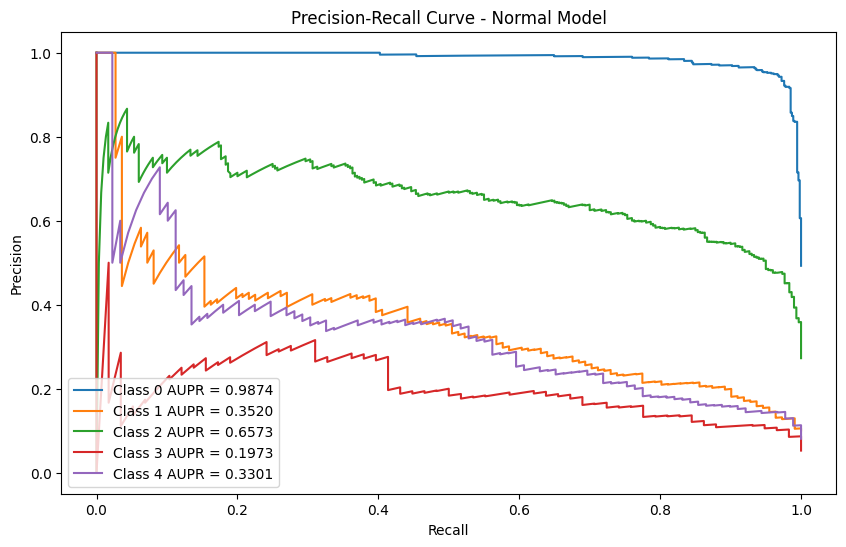

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/normal_model_56.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models/quantum_hybrid_model_56.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)